# Automatic BSPF Trigger Plots

Creates automatic event plots based on catalog 

In [1]:
import os, pprint
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from andbro__savefig import __savefig
from tqdm.notebook import tqdm
from functions.request_data import __request_data


In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [3]:
# def __request_data(seed, tbeg, tend):

#     from obspy.clients.fdsn import Client

#     client = Client("IRIS")

#     net, sta, loc, cha = seed.split(".")

#     try:
#         inventory = client.get_stations(network=net, 
#                                          station=sta,
#                                          starttime=tbeg,
#                                          endtime=tend,
#                                          level="response",
#                                          )
#     except:
#         print(" -> Failed to load inventory!")
#         inventory = None
        
#     try:
#         waveform = client.get_waveforms(network=net,
#                                        station=sta,
#                                        location=loc,
#                                        channel=cha, 
#                                        starttime=tbeg-60,
#                                        endtime=tend+60,
#                                        )

#     except:
#         print(" -> Failed to load waveforms!")
#         waveform = None
    
#     return waveform, inventory

In [4]:
def __add_distances_and_backazimuth(config, df):

    from obspy.geodetics.base import gps2dist_azimuth

    dist = np.zeros(len(df))
    baz = np.zeros(len(df))

    
    for ii, ev in enumerate(df.index):
        try:
            dist[ii], az, baz[ii] = gps2dist_azimuth(config['BSPF_lat'], config['BSPF_lon'],
                                                     df.latitude[ii], df.longitude[ii],
                                                     a=6378137.0, f=0.0033528106647474805
                                                     )
        except:
            print(" -> failed to compute!")
            
    df['backazimuth'] = baz
    df['distances_km'] = dist/1000

    return df

In [5]:
# def __process_bspf(config, st, inv):

#     py_bspf = st.copy()

#     ## merge traces that might be split due to data gaps or overlaps
# #     py_bspf.merge(fill_value="interpolate")

#     ## cut to event
# #     py_bspf.trim(config['tbeg'], config['tend'])

#     ## renove sensitivity
# #     py_bspf.remove_sensitivity(inv)

#     ## remove mean
#     py_bspf.detrend("demean")

#     ## apply taper
#     py_bspf.taper(0.1)

#     ## bandpass filter
#     py_bspf = py_bspf.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

#     ## adjust channel names
#     for tr in py_bspf:
#         if tr.stats.channel[-1] == "1":
#             tr.stats.channel = str(tr.stats.channel).replace("1","E")
#         if tr.stats.channel[-1] == "2":
#             tr.stats.channel = str(tr.stats.channel).replace("2","N")        
#         if tr.stats.channel[-1] == "3":
#             tr.stats.channel = str(tr.stats.channel).replace("3","Z")

#     ## show all traces in data stream
# #     print(py_bspf)
    
#     return py_bspf

In [6]:
def __process_xpfo(config, st, inv):

    ii_pfo = st.copy()

#     pre_filt = [0.005, 0.01, 19, 20]

    ## cut properly
#     ii_pfo.trim(config['tbeg'], config['tend'])

    ## demean
    ii_pfo.detrend("demean")

    ## remove response
#     ii_pfo.remove_response(inventory=inv, 
#     #                        pre_filt=pre_filt, 
#                            output="VEL",
#     #                        water_level=60, 
#                            plot=False)

    ## taper 
    ii_pfo.taper(0.1)

    ## bandpass
    ii_filter = ii_pfo.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)

    ## adjust channel names
    for tr in ii_pfo:
        if tr.stats.channel[-1] == "1":
            tr.stats.channel = str(tr.stats.channel).replace("1","N")
        if tr.stats.channel[-1] == "2":
            tr.stats.channel = str(tr.stats.channel).replace("2","E")
    
    return ii_pfo

In [7]:
def __makeplot(config, st):

    
    st_in = st.copy()
    
    fig, ax = plt.subplots(6,1, figsize=(15,10), sharex=True)

    font = 14

    time_scaling, time_unit = 1, "sec"
    rot_scaling = 1e9
    trans_scaling = 1e6
    
    for i, tr in enumerate(st_in):
        
        if i in [0,1,2]:
            ax[i].set_ylabel(r"$\omega$ (nrad/s)", fontsize=font)
            ax[i].plot(tr.times()/time_scaling, tr.data*rot_scaling, 'k', label=tr.stats.station+"."+tr.stats.channel)

        elif i in [3,4,5]:
            ax[i].set_ylabel(r"u ($\mu$m/s)", fontsize=font)
            ax[i].plot(tr.times()/time_scaling, tr.data*trans_scaling, 'k', label=tr.stats.station+"."+tr.stats.channel)
            
        ax[i].legend(loc=1)
        
    ax[5].set_xlabel(f"Time ({time_unit}) from {st[0].stats.starttime.date} {str(st[0].stats.starttime.time).split('.')[0]} UTC", fontsize=font)
    ax[0].set_title(config['title']+f" | {config['fmin']} - {config['fmax']} Hz | M{cat.events[jj].magnitudes[0].mag}", fontsize=font, pad=10)
    
    plt.show();
    del st_in
    return fig

In [8]:
def __makeplotStreamSpectra2(st, config, fscale=None):

    from scipy import fftpack
    from andbro__fft import __fft
    import matplotlib.pyplot as plt

    st_in = st.copy()
    
    NN = len(st_in)
    rot_scaling, rot_unit = 1e9, r"nrad/s"
    trans_scaling, trans_unit = 1e6, r"$\mu$m/s"
        
    fig, axes = plt.subplots(NN,2,figsize=(15,int(NN*2)), sharex='col')

    font = 14
    
    plt.subplots_adjust(hspace=0.3)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)
    
    for i, tr in enumerate(st_in):

#         comp_fft = abs(fftpack.fft(tr.data))
#         ff       = fftpack.fftfreq(comp_fft.size, d=1/tr.stats.sampling_rate)
#         comp_fft = fftpack.fftshift(comp_fft)
#         ff, spec = ff[1:len(ff)//2], abs(fftpack.fft(tr.data)[1:len(ff)//2])

        if tr.stats.channel[-2] == "J":
            scaling = rot_scaling
        elif tr.stats.channel[-2] == "H":
            scaling = trans_scaling

        spec, ff, ph = __fft(tr.data*scaling, tr.stats.delta, window=None, normalize=None)
    
    
        ## _________________________________________________________________
        if tr.stats.channel[-2] == "J":
            axes[i,0].plot(
                        tr.times(),
                        tr.data*rot_scaling,
                        color='black',
                        label='{} {}'.format(tr.stats.station, tr.stats.channel),
                        lw=1.0,
                        )

        elif tr.stats.channel[-2] == "H":
            axes[i,0].plot(
                        tr.times(),
                        tr.data*trans_scaling,
                        color='black',
                        label='{} {}'.format(tr.stats.station, tr.stats.channel),
                        lw=1.0,
                        )
        ## _________________________________________________________________
        if fscale == "loglog":
            axes[i,1].loglog(ff, spec, color='black', lw=1.0)
        elif fscale == "loglin":
            axes[i,1].semilogx(ff, spec, color='black', lw=1.0)
        elif fscale == "linlog":
            axes[i,1].semilogy(ff, spec, color='black', lw=1.0)
        else:
            axes[i,1].plot(ff, spec, color='black', lw=1.0)         
        
        
        if tr.stats.channel[1] == "J":
            sym, unit = r"$\Omega$", rot_unit
        elif tr.stats.channel[1] == "H":
            sym, unit = "v", trans_unit
        else:
            unit = "Amplitude", "a.u."
            
        axes[i,0].set_ylabel(f'{sym} ({unit})',fontsize=font)    
        axes[i,1].set_ylabel(f'ASD \n({unit}/Hz)',fontsize=font)        
        axes[i,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.10), framealpha=1.0)
        
#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    if "fmin" in config.keys() and "fmax" in config.keys():
        axes[i,1].set_xlim(config['fmin'],config['fmax'])

    axes[NN-1,0].set_xlabel(f"Time from {tr.stats.starttime.date} {str(tr.stats.starttime.time)[:8]} (s)",fontsize=font)     
    axes[NN-1,1].set_xlabel(f"Frequency (Hz)",fontsize=font)     

    del st_in
    return fig

## Configurations

In [9]:
config = {}

In [10]:
## location of BSPF
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643

## path for figures to store
config['outpath_figs'] = data_path+"BSPF/figures/triggered2/"

config['path_trigger'] = data_path+"BSPF/trigger2/"

## blueSeis sensor
config['seed_blueseis'] = "PY.BSPF..HJ*"

## Trillium 240 next to BlueSeis on Pier
config['seed_seismometer'] = "II.PFO.10.BH*" 
# config['seed_seismometer'] = "PY.BSPF..HH*" 

## Event Info

In [11]:
def __read_pickle(path, filename):
    
    import pickle

    with open(path+filename, 'rb') as f:
        triggerfile = pickle.load(f)
        
    return triggerfile

In [12]:
trigger_events = __read_pickle(config['path_trigger'], "trigger_all.pkl")

In [13]:
trigger_events_df = pd.DataFrame()

trigger_events_df['origin'] = [trig['time'] for trig in trigger_events]
trigger_events_df['duration'] = [trig['duration'] for trig in trigger_events]

events = trigger_events_df

In [14]:
trigger_events_df

origin  duration
0   2022-10-02T03:25:19.344538Z    51.050
1   2022-10-03T16:08:19.219538Z    58.550
2   2022-10-03T16:08:19.219538Z    58.550
3   2022-10-05T15:39:17.944539Z    68.925
4   2022-10-07T22:45:15.894539Z    60.100
..                          ...       ...
68  2023-03-24T15:04:12.119538Z    58.900
69  2023-03-27T09:29:03.444538Z    56.975
70  2023-03-31T12:05:42.244538Z    53.050
71  2023-03-31T12:05:42.244538Z    53.050
72  2023-03-31T13:37:05.019538Z    57.950

[73 rows x 2 columns]

In [15]:
trigger_events_errors = __read_pickle(config['path_trigger'], "trigger_all_errors.pkl")
trigger_events_errors

[]

## Matched Events

In [16]:
cat = obs.read_events(config['path_trigger']+"matched_catalog_events.xml")

In [17]:
cat

73 Event(s) in Catalog:
2022-10-02T03:25:16.440000Z | +33.484, -116.508 | 1.49 ml | manual
2022-10-03T16:08:09.970000Z | +33.925, -116.921 | 3.01 ml | manual
...
2023-03-30T23:07:26.570000Z | +33.593, -116.808 | 0.99 ml | manual
2023-03-30T23:07:26.570000Z | +33.593, -116.808 | 0.99 ml | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'

## RUN LOOP

 -> 0 2022-10-02T03:25:19.344538Z 
 -> sensitivity removed!
 -> response removed!


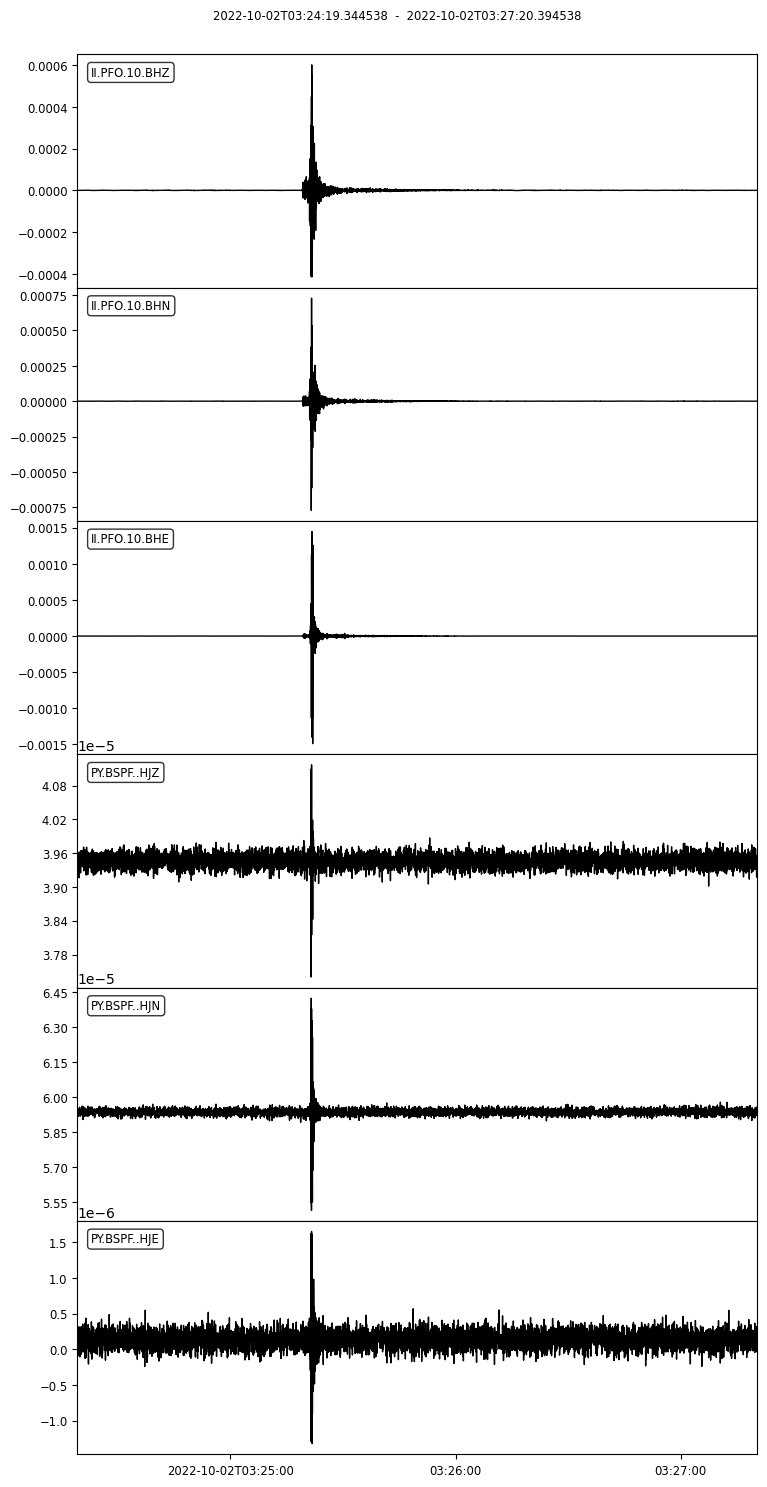

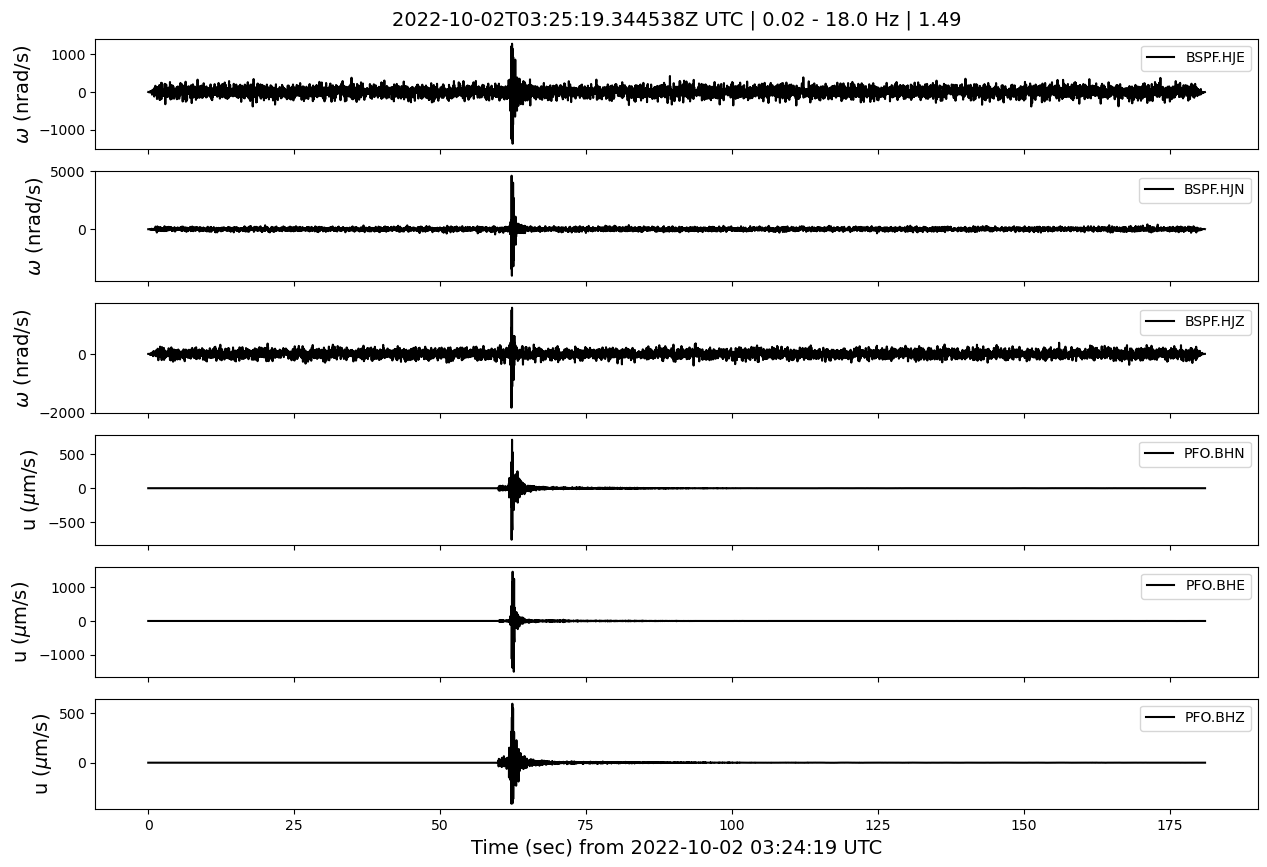


   -> saving /home/andbro/kilauea-data/BSPF/figures/triggered2/raw/20221002T032519_M1.49_raw.png ...

   -> Done


   -> saving /home/andbro/kilauea-data/BSPF/figures/triggered2/filtered/20221002T032519_M1.49_traces.png ...

   -> Done

 -> 1 2022-10-03T16:08:19.219538Z 
 -> sensitivity removed!
 -> response removed!


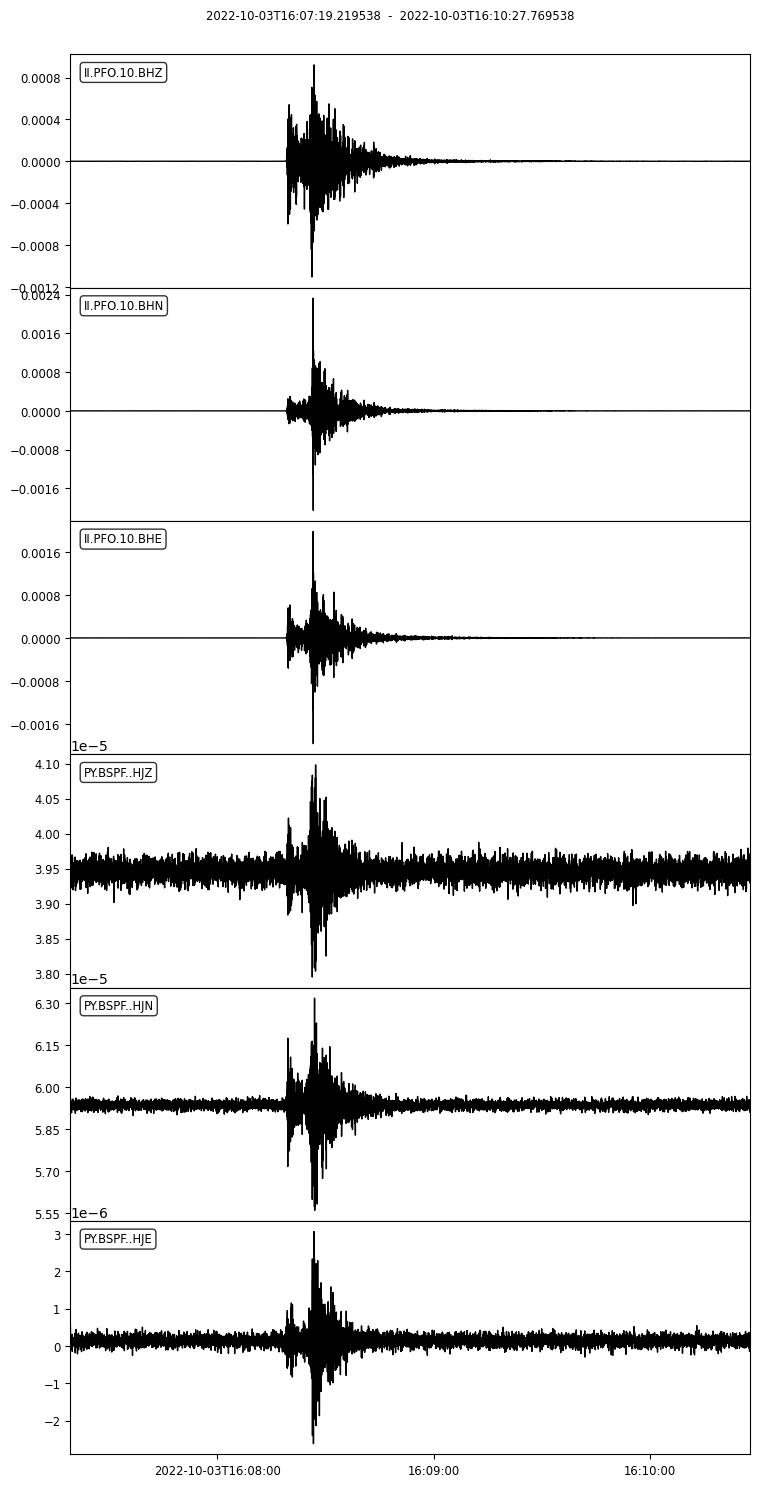

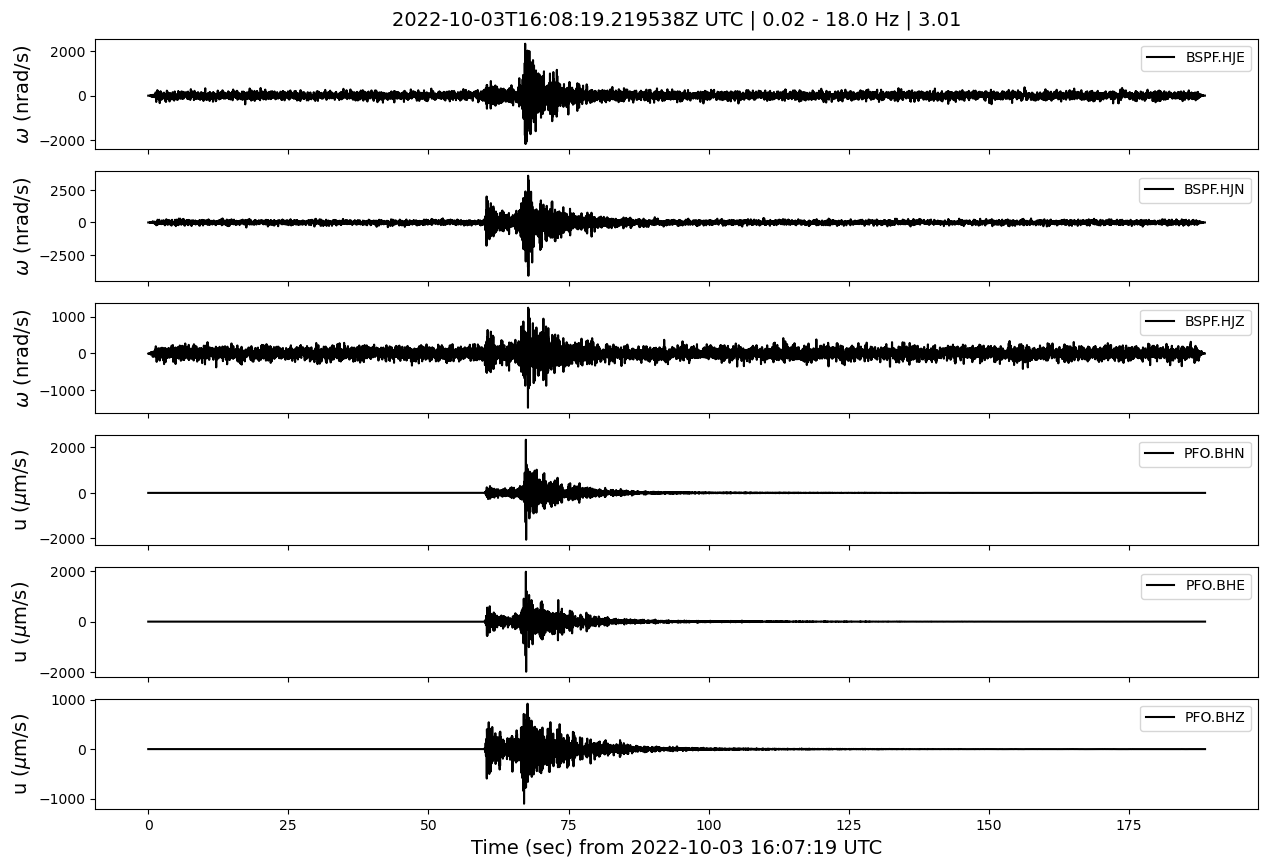


   -> saving /home/andbro/kilauea-data/BSPF/figures/triggered2/raw/20221003T160819_M3.01_raw.png ...

   -> Done


   -> saving /home/andbro/kilauea-data/BSPF/figures/triggered2/filtered/20221003T160819_M3.01_traces.png ...

   -> Done

 -> 2 2022-10-03T16:08:19.219538Z 
 -> sensitivity removed!
 -> response removed!


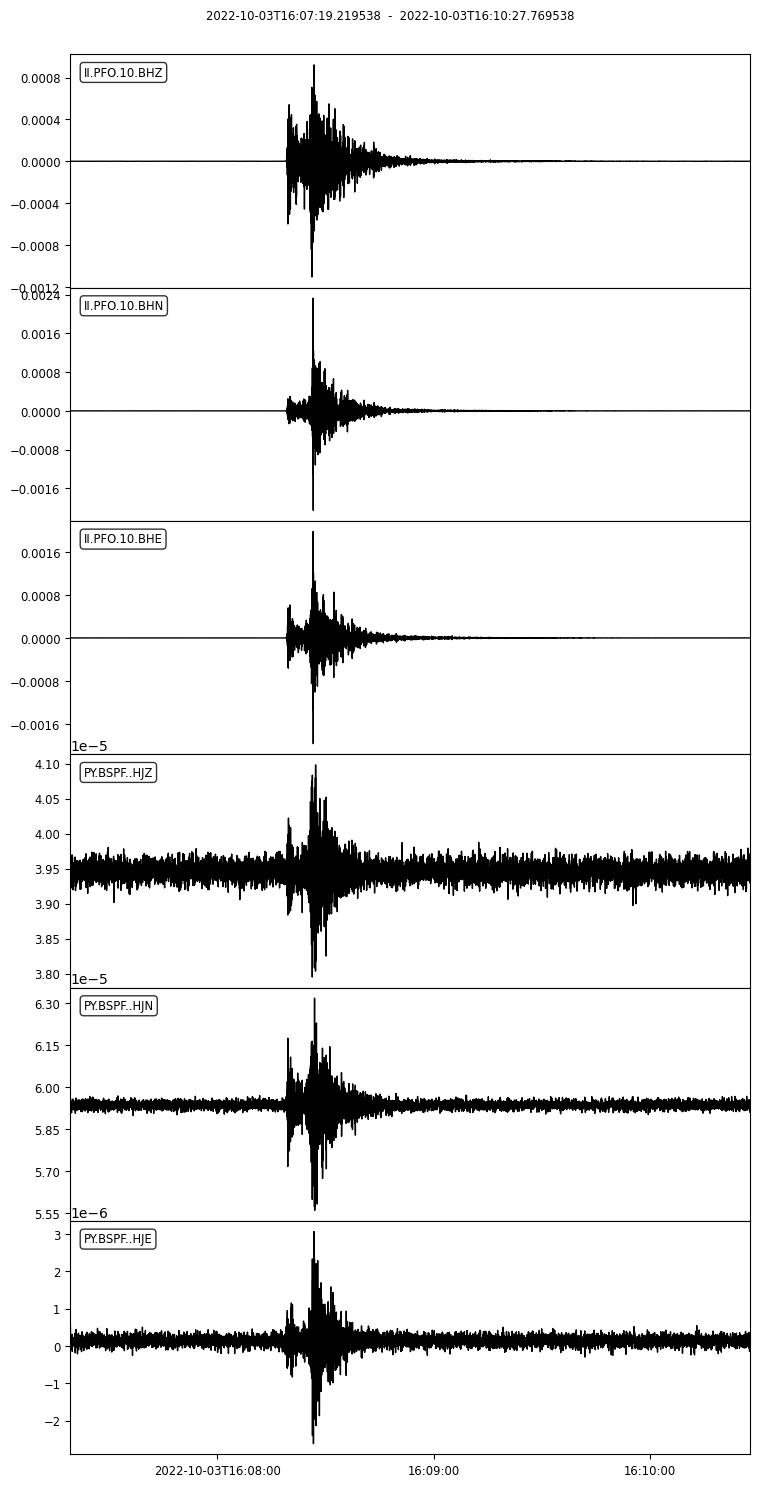

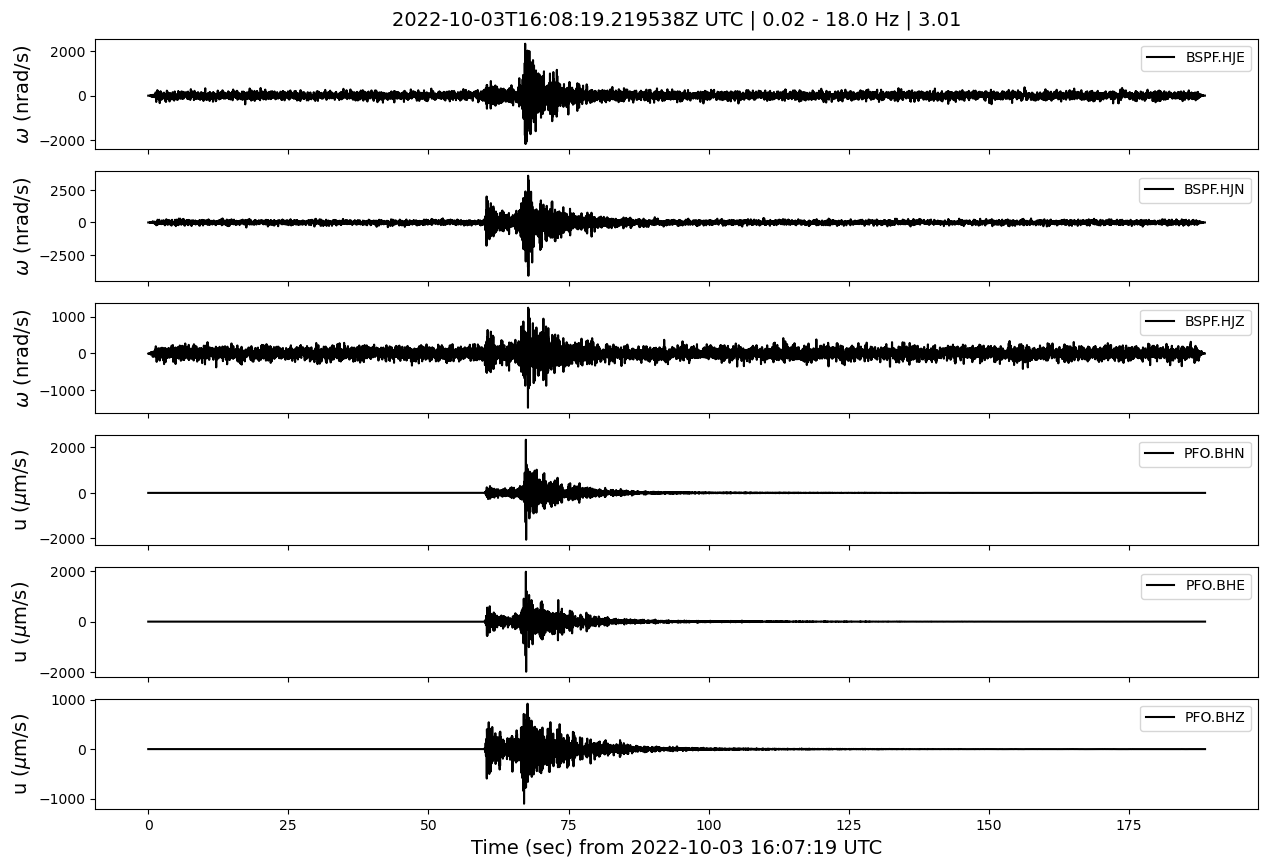


   -> saving /home/andbro/kilauea-data/BSPF/figures/triggered2/raw/20221003T160819_M3.01_raw.png ...

   -> Done


   -> saving /home/andbro/kilauea-data/BSPF/figures/triggered2/filtered/20221003T160819_M3.01_traces.png ...

   -> Done

 -> 3 2022-10-05T15:39:17.944539Z 
 -> sensitivity removed!
 -> response removed!


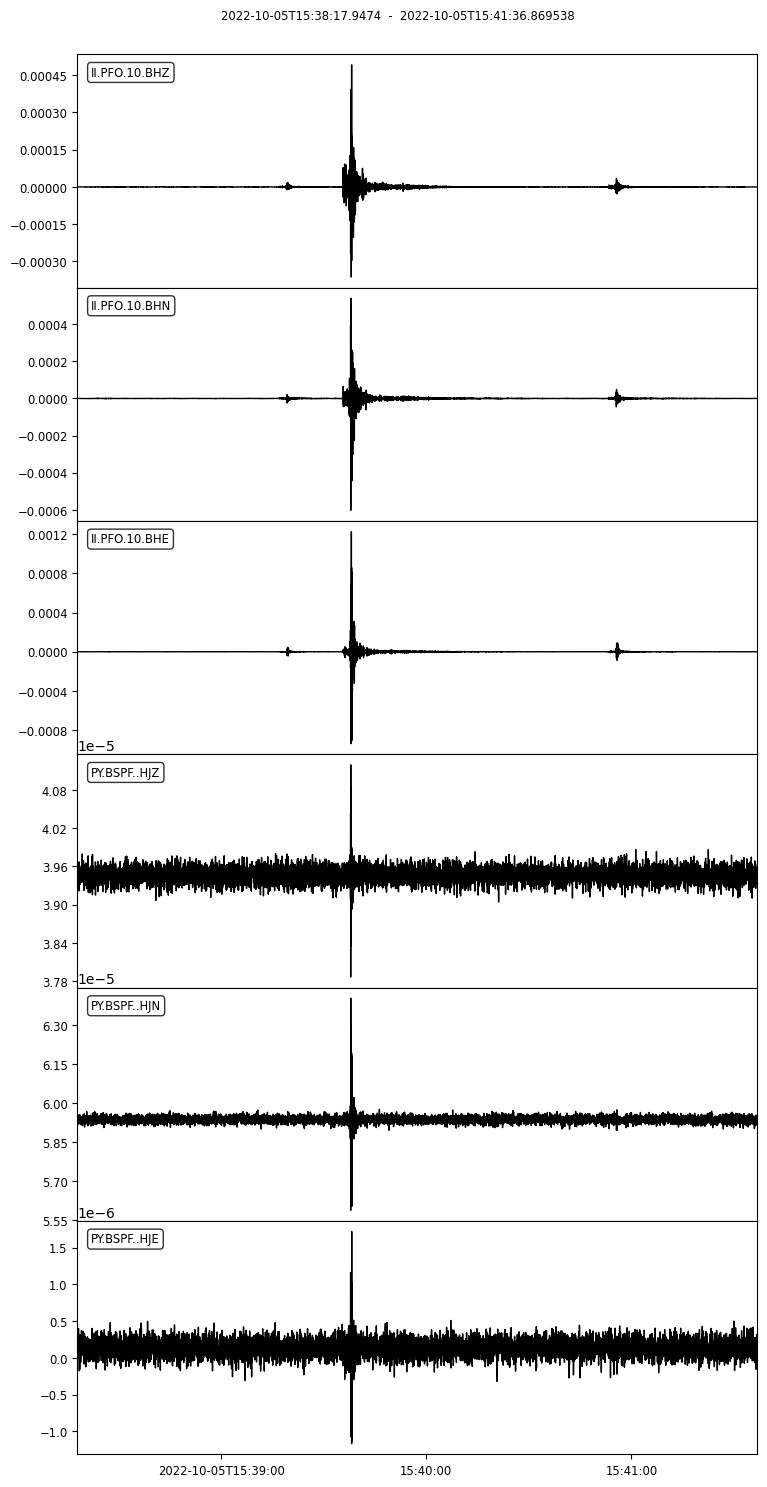

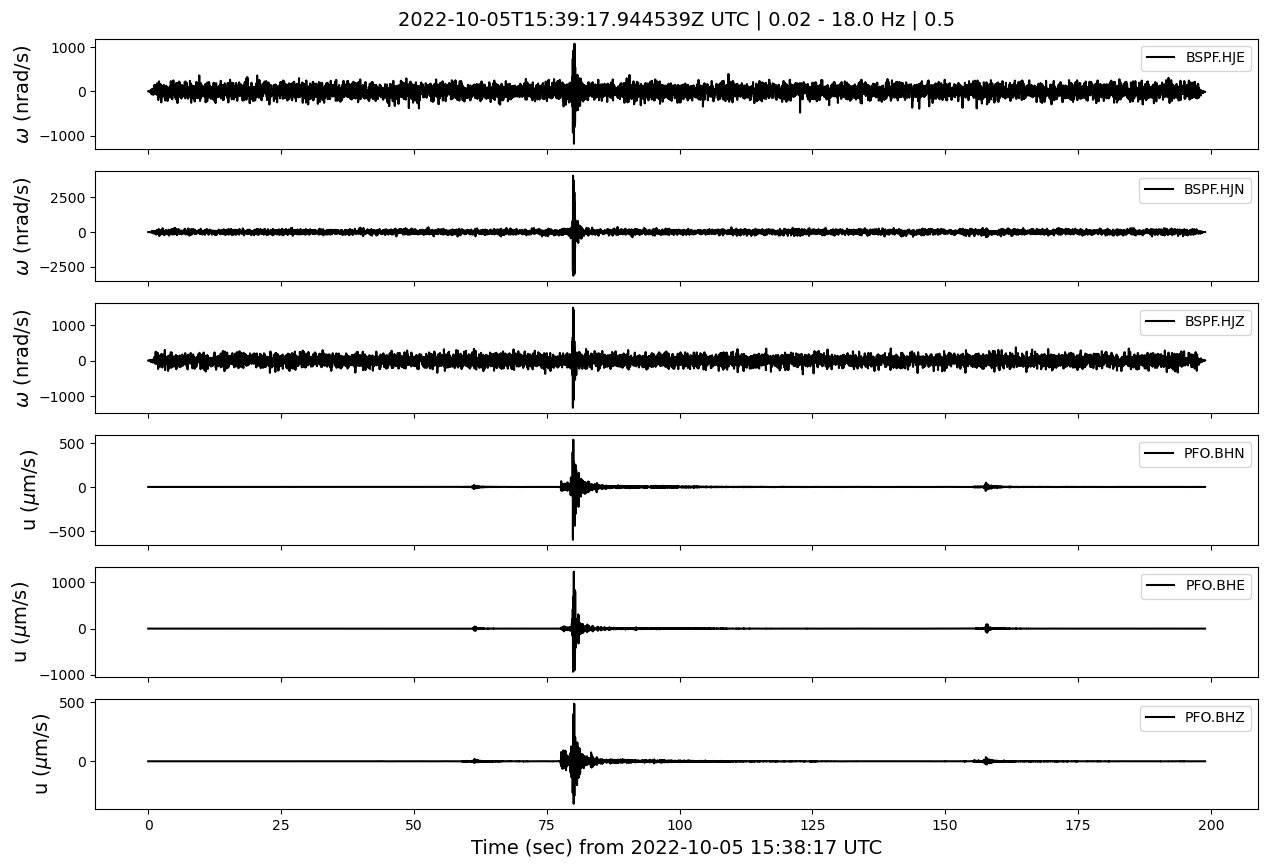


   -> saving /home/andbro/kilauea-data/BSPF/figures/triggered2/raw/20221005T153917_M0.5_raw.png ...

   -> Done


   -> saving /home/andbro/kilauea-data/BSPF/figures/triggered2/filtered/20221005T153917_M0.5_traces.png ...

   -> Done

 -> 4 2022-10-07T22:45:15.894539Z 
10.424539
 -> 5 2022-10-08T02:52:36.369539Z 
 -> sensitivity removed!
 -> response removed!


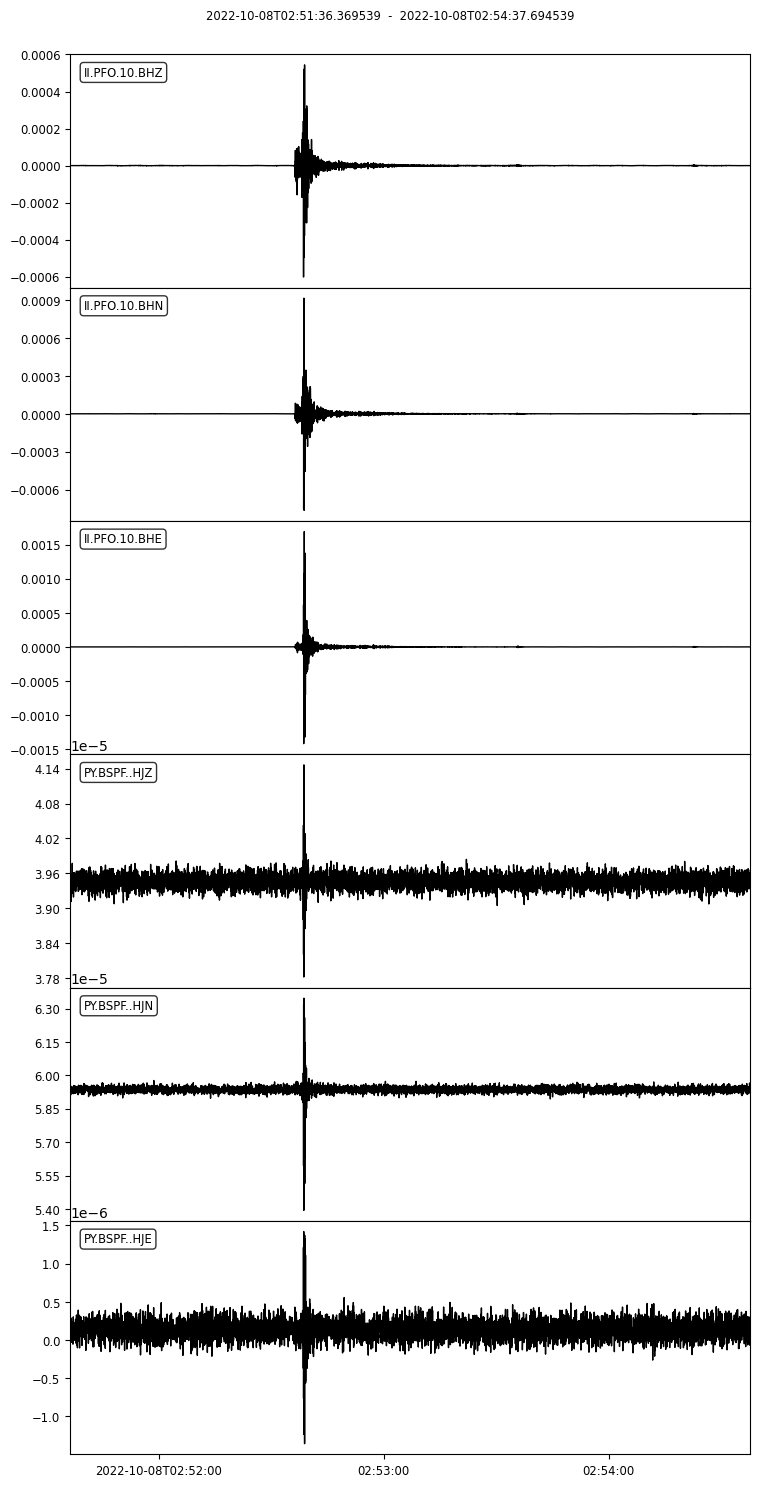

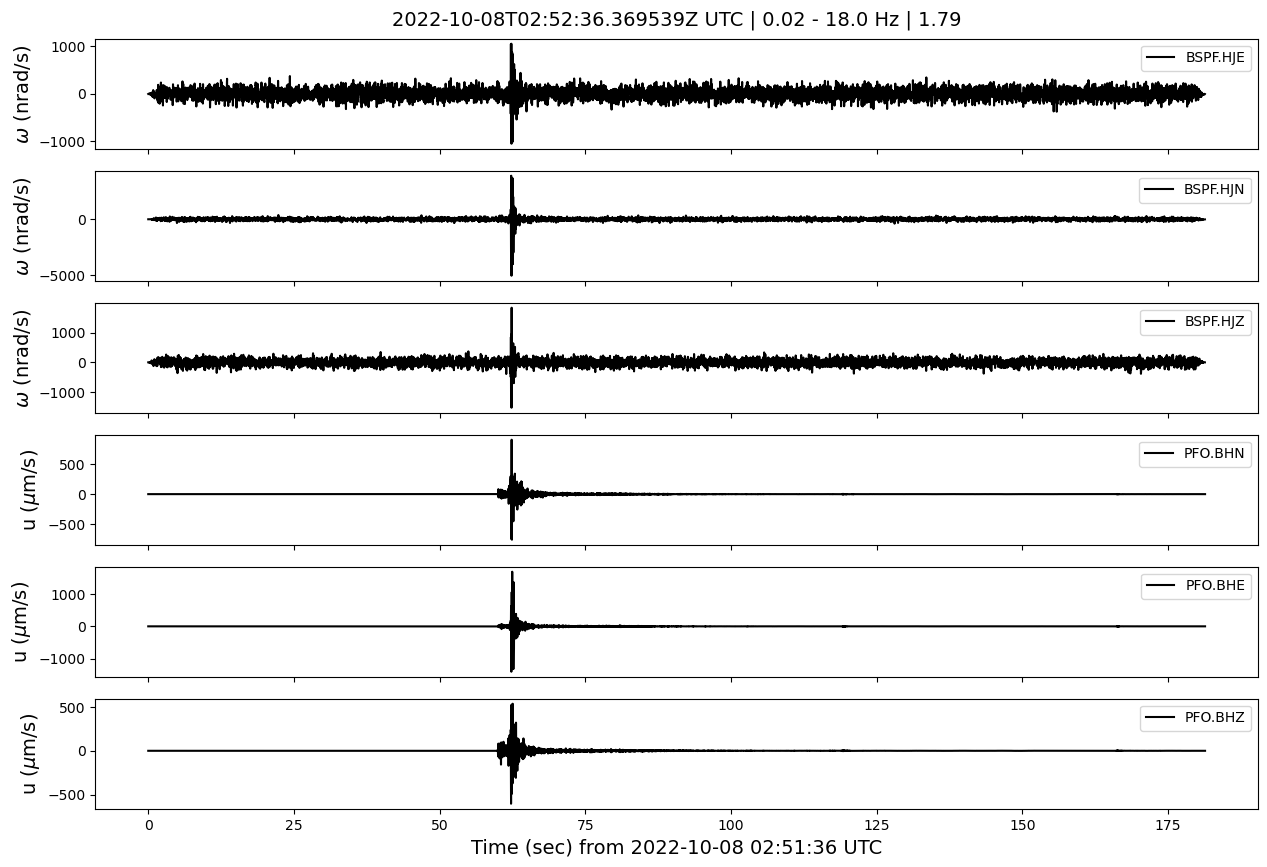


   -> saving /home/andbro/kilauea-data/BSPF/figures/triggered2/raw/20221008T025236_M1.79_raw.png ...

   -> Done


   -> saving /home/andbro/kilauea-data/BSPF/figures/triggered2/filtered/20221008T025236_M1.79_traces.png ...

   -> Done

 -> 6 2022-10-15T05:17:36.519538Z 
 -> sensitivity removed!
 -> response removed!


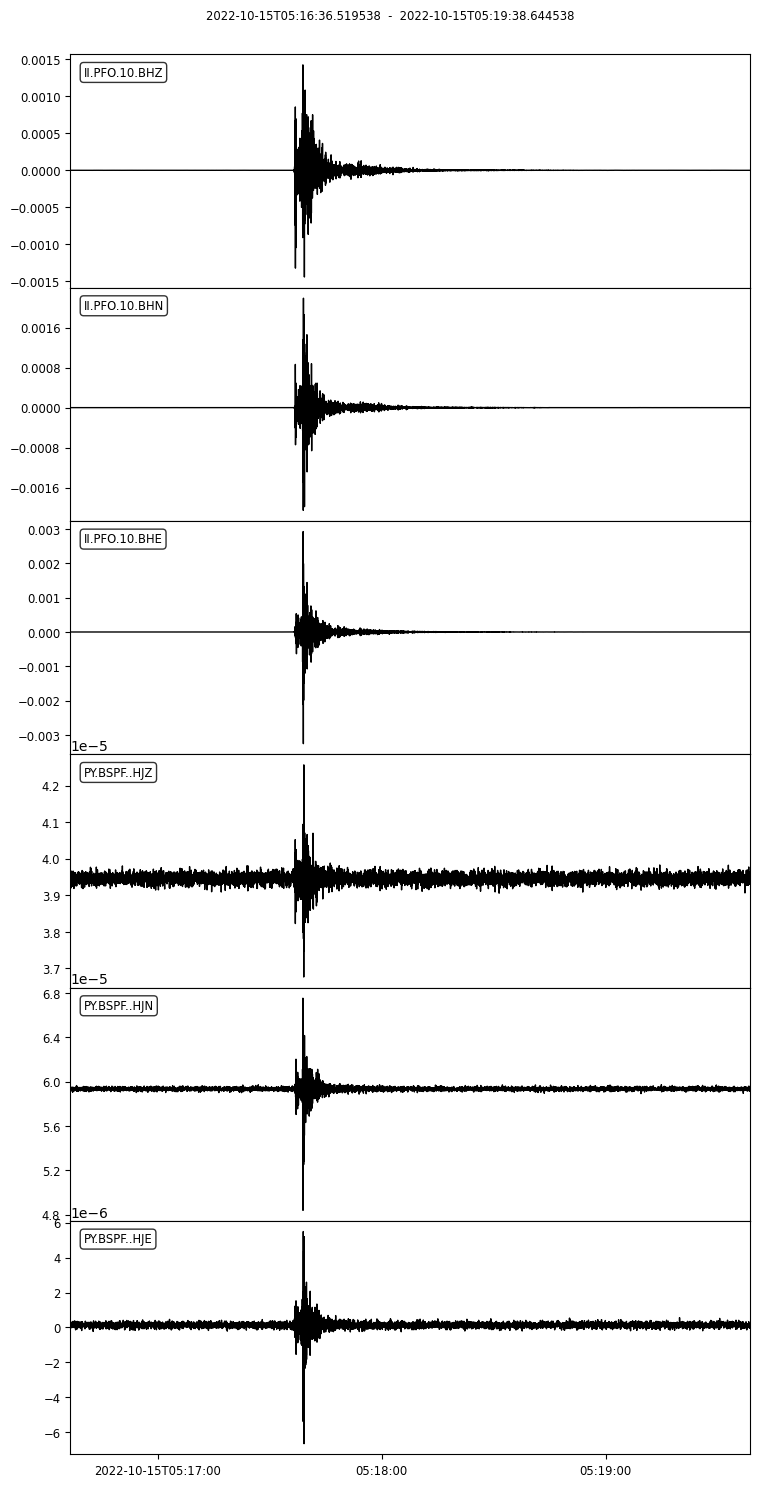

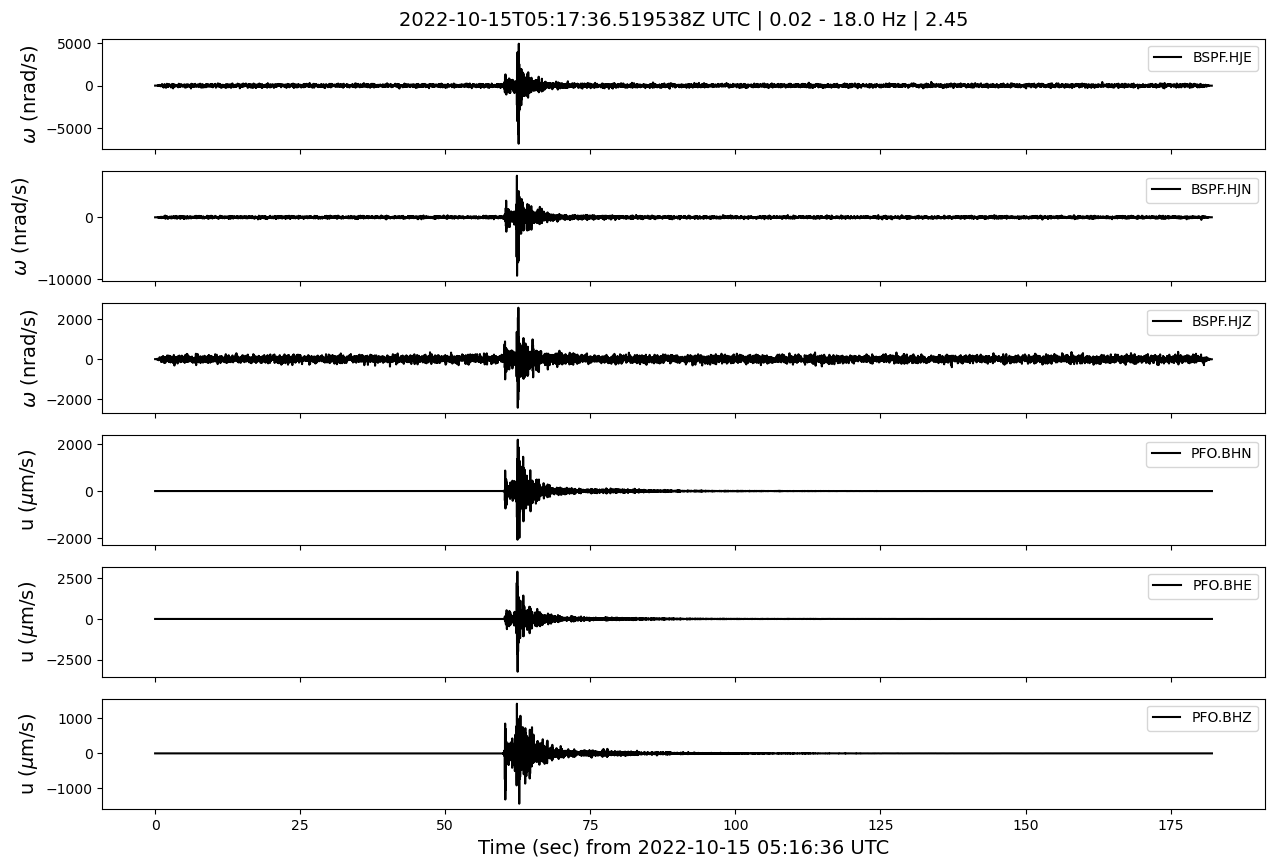


   -> saving /home/andbro/kilauea-data/BSPF/figures/triggered2/raw/20221015T051736_M2.45_raw.png ...

   -> Done


   -> saving /home/andbro/kilauea-data/BSPF/figures/triggered2/filtered/20221015T051736_M2.45_traces.png ...

   -> Done

 -> 7 2022-10-17T05:25:36.319539Z 
 -> sensitivity removed!
 -> response removed!


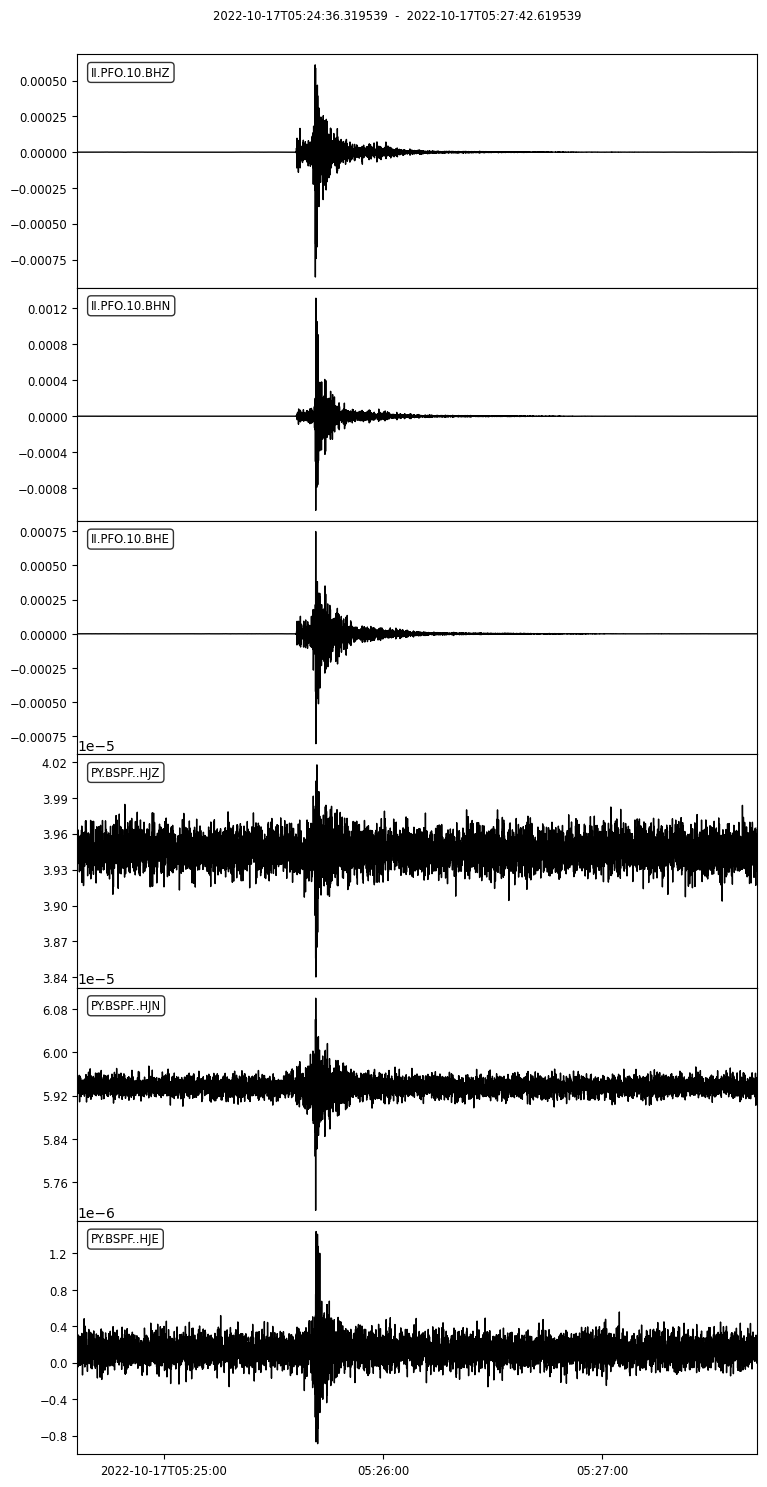

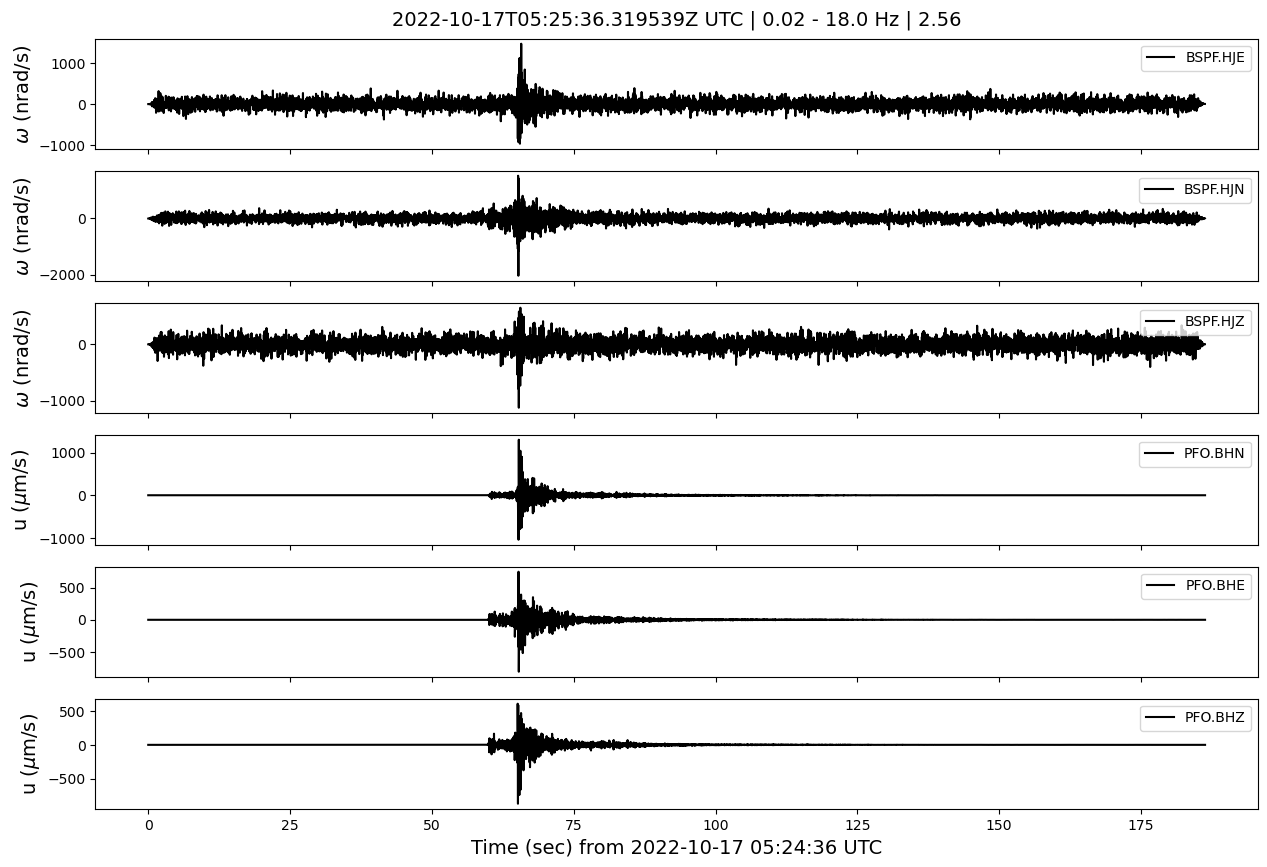


   -> saving /home/andbro/kilauea-data/BSPF/figures/triggered2/raw/20221017T052536_M2.56_raw.png ...

   -> Done


   -> saving /home/andbro/kilauea-data/BSPF/figures/triggered2/filtered/20221017T052536_M2.56_traces.png ...

   -> Done

 -> 8 2022-10-23T09:24:59.844538Z 
 -> sensitivity removed!
 -> response removed!


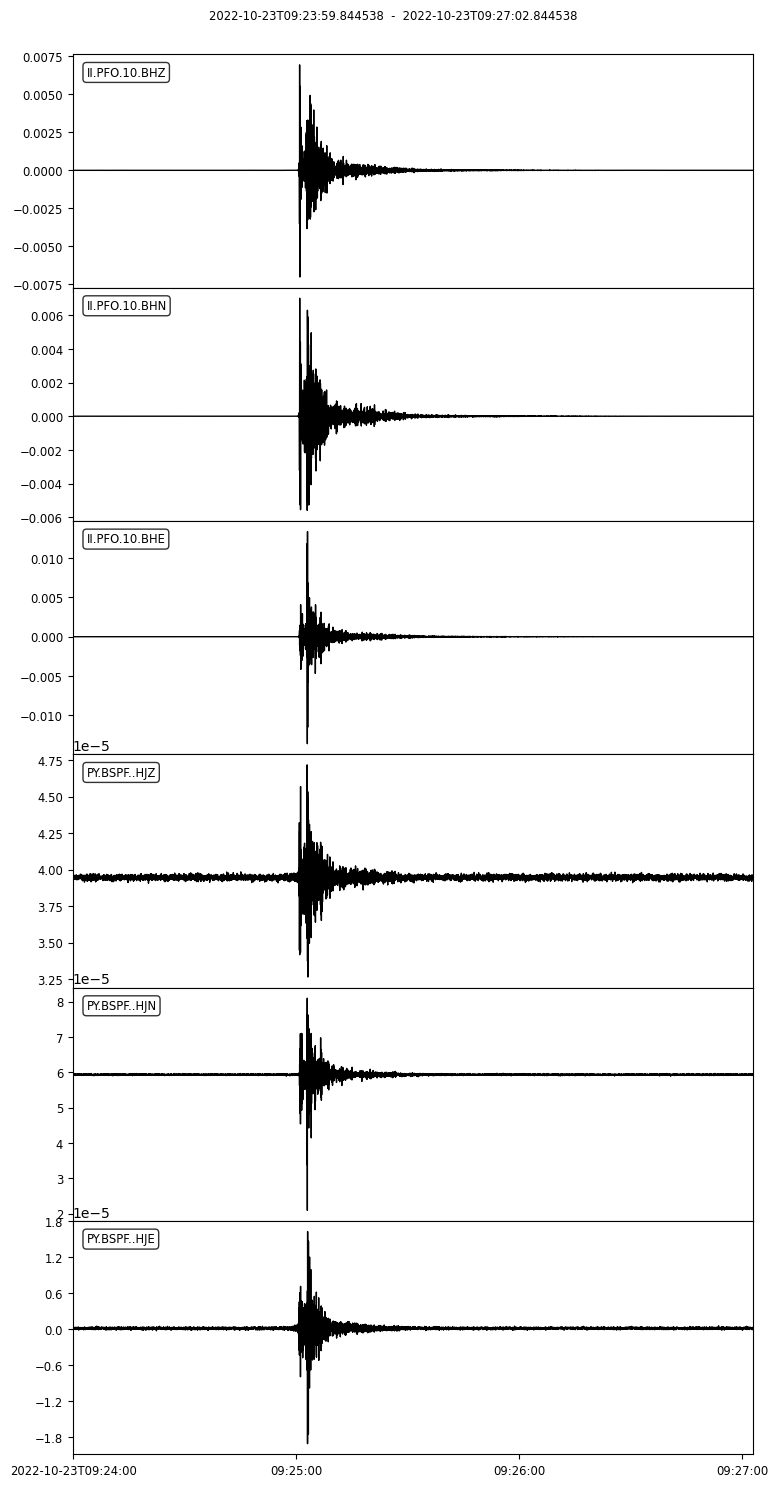

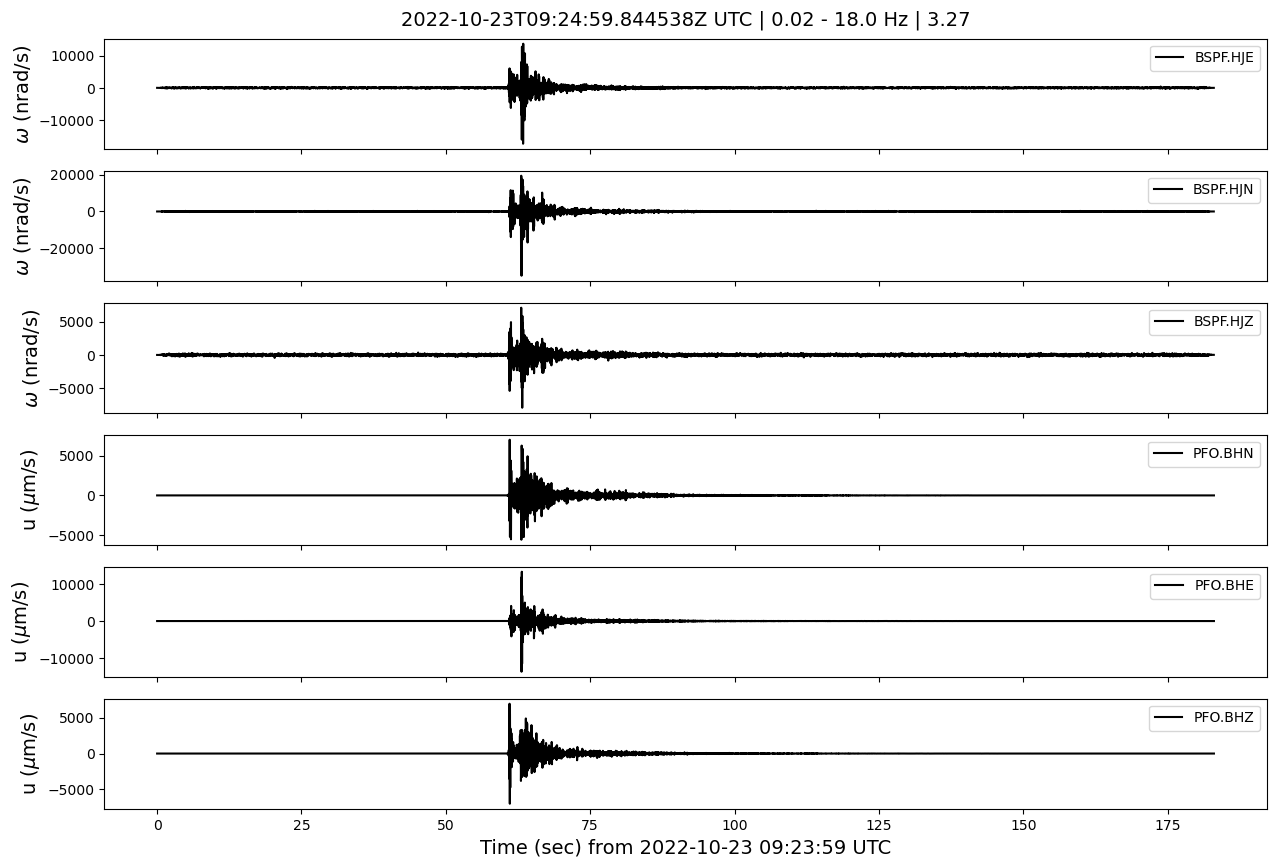


   -> saving /home/andbro/kilauea-data/BSPF/figures/triggered2/raw/20221023T092459_M3.27_raw.png ...

   -> Done


   -> saving /home/andbro/kilauea-data/BSPF/figures/triggered2/filtered/20221023T092459_M3.27_traces.png ...

   -> Done

 -> 9 2022-10-25T03:55:36.344538Z 
 -> sensitivity removed!
 -> response removed!


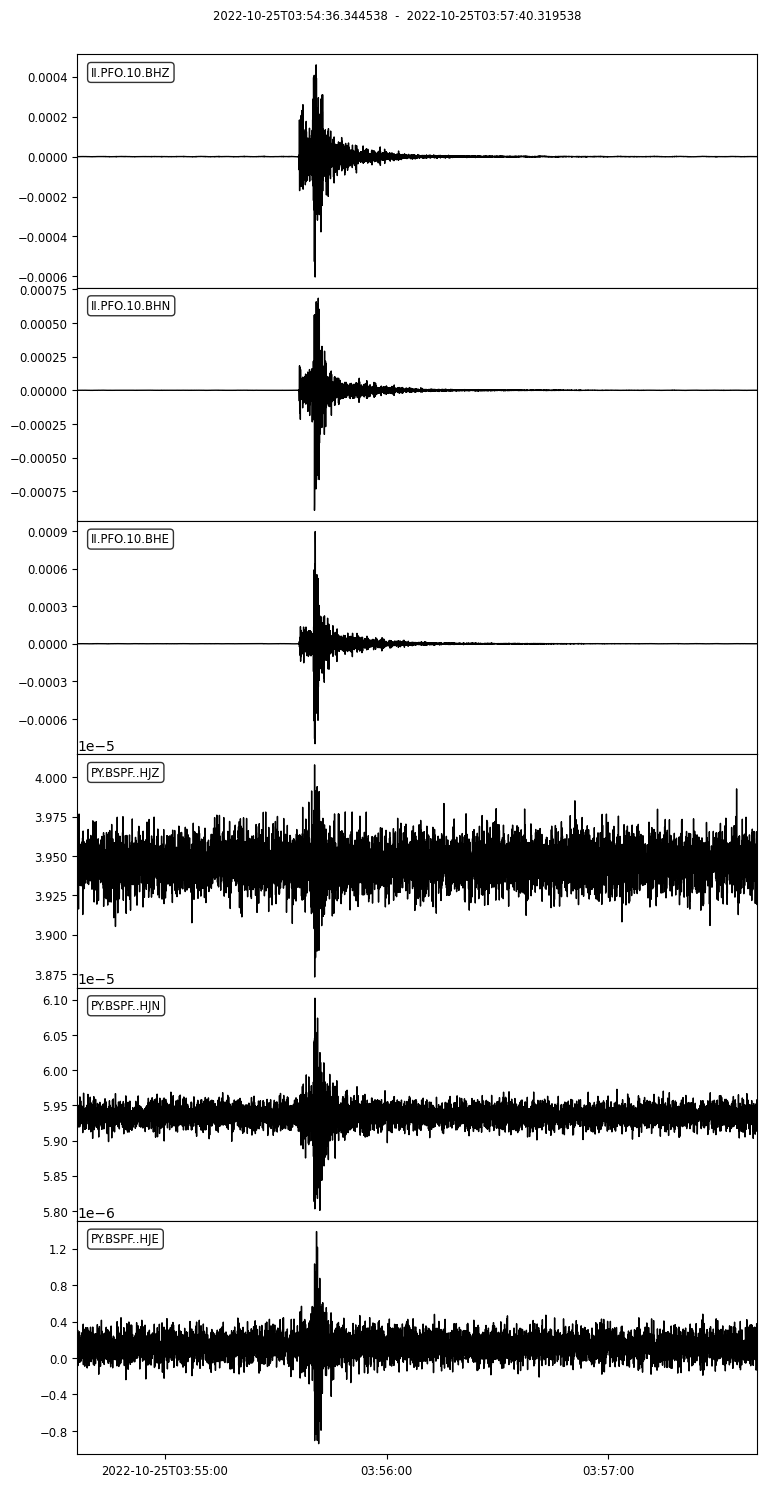

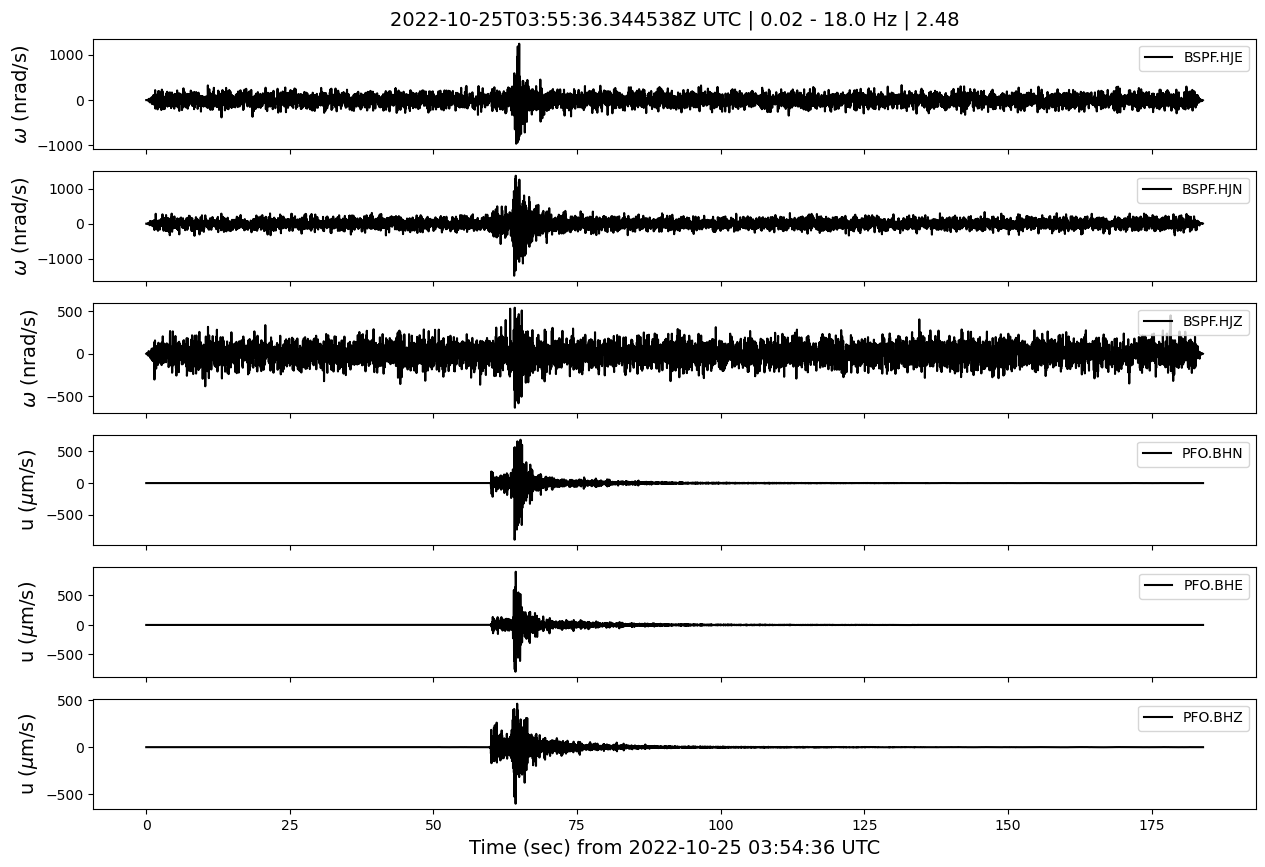


   -> saving /home/andbro/kilauea-data/BSPF/figures/triggered2/raw/20221025T035536_M2.48_raw.png ...

   -> Done


   -> saving /home/andbro/kilauea-data/BSPF/figures/triggered2/filtered/20221025T035536_M2.48_traces.png ...

   -> Done

 -> 10 2022-10-25T03:55:40.019538Z 
 -> sensitivity removed!
 -> response removed!


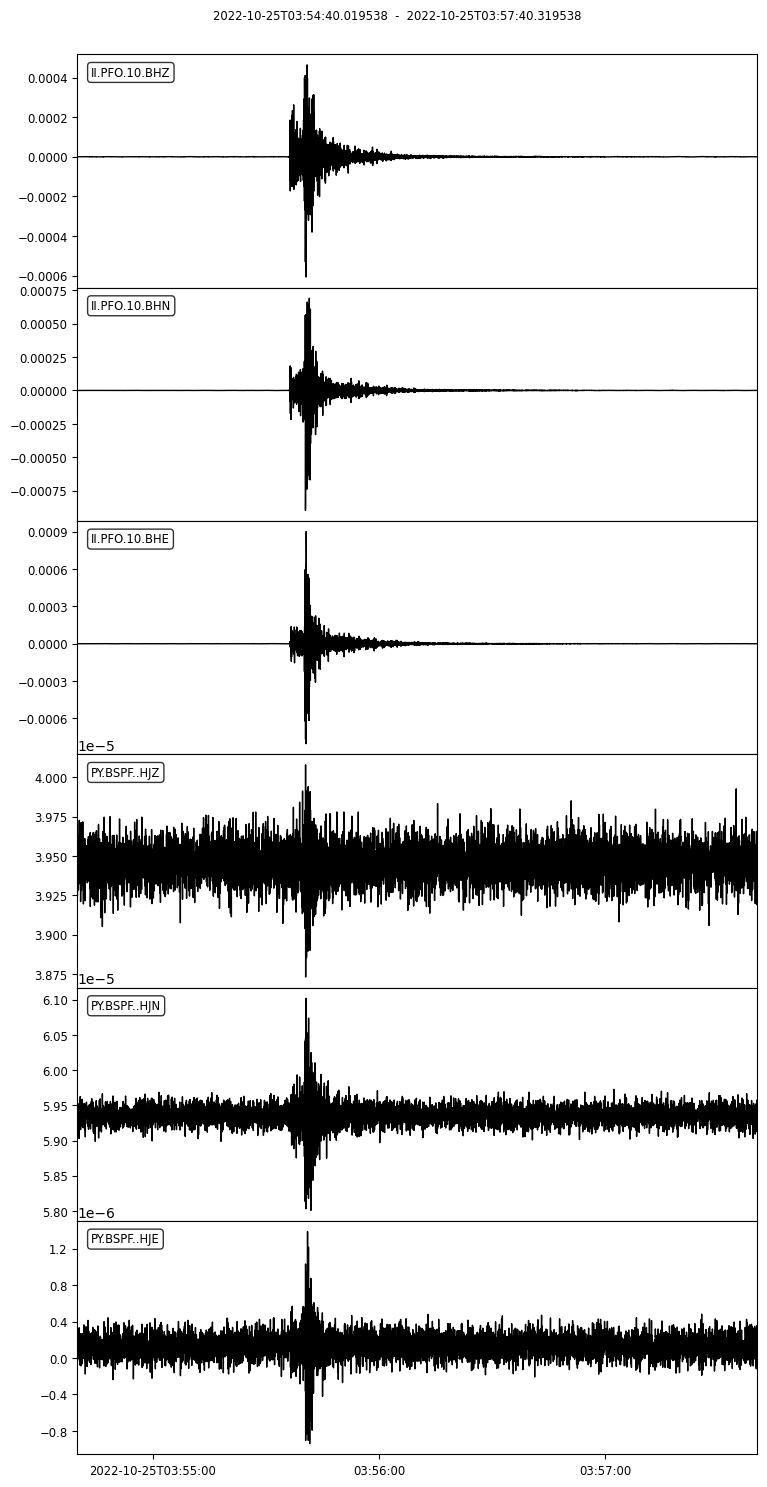

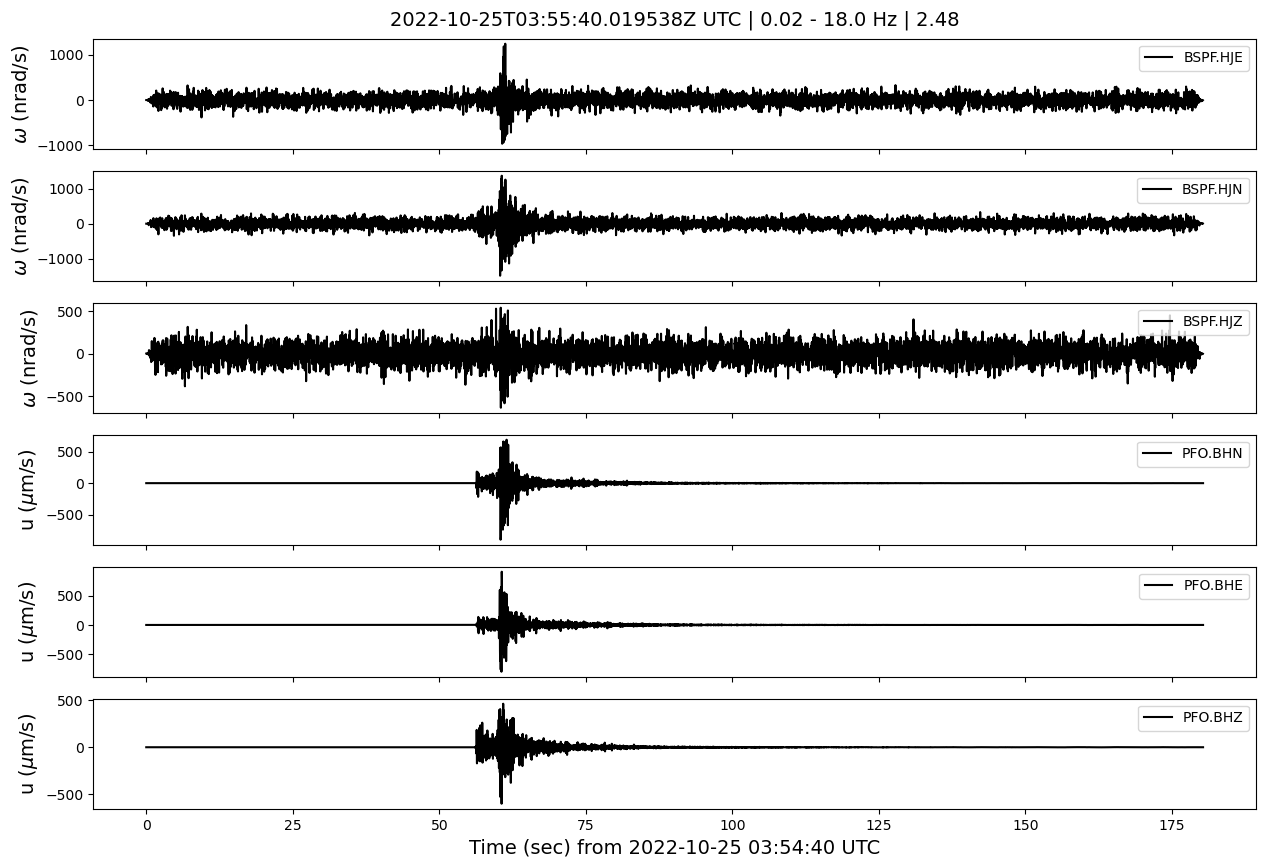


   -> saving /home/andbro/kilauea-data/BSPF/figures/triggered2/raw/20221025T035540_M2.48_raw.png ...

   -> Done


   -> saving /home/andbro/kilauea-data/BSPF/figures/triggered2/filtered/20221025T035540_M2.48_traces.png ...

   -> Done

 -> 11 2022-10-25T12:29:49.444538Z 
 -> sensitivity removed!
 -> response removed!


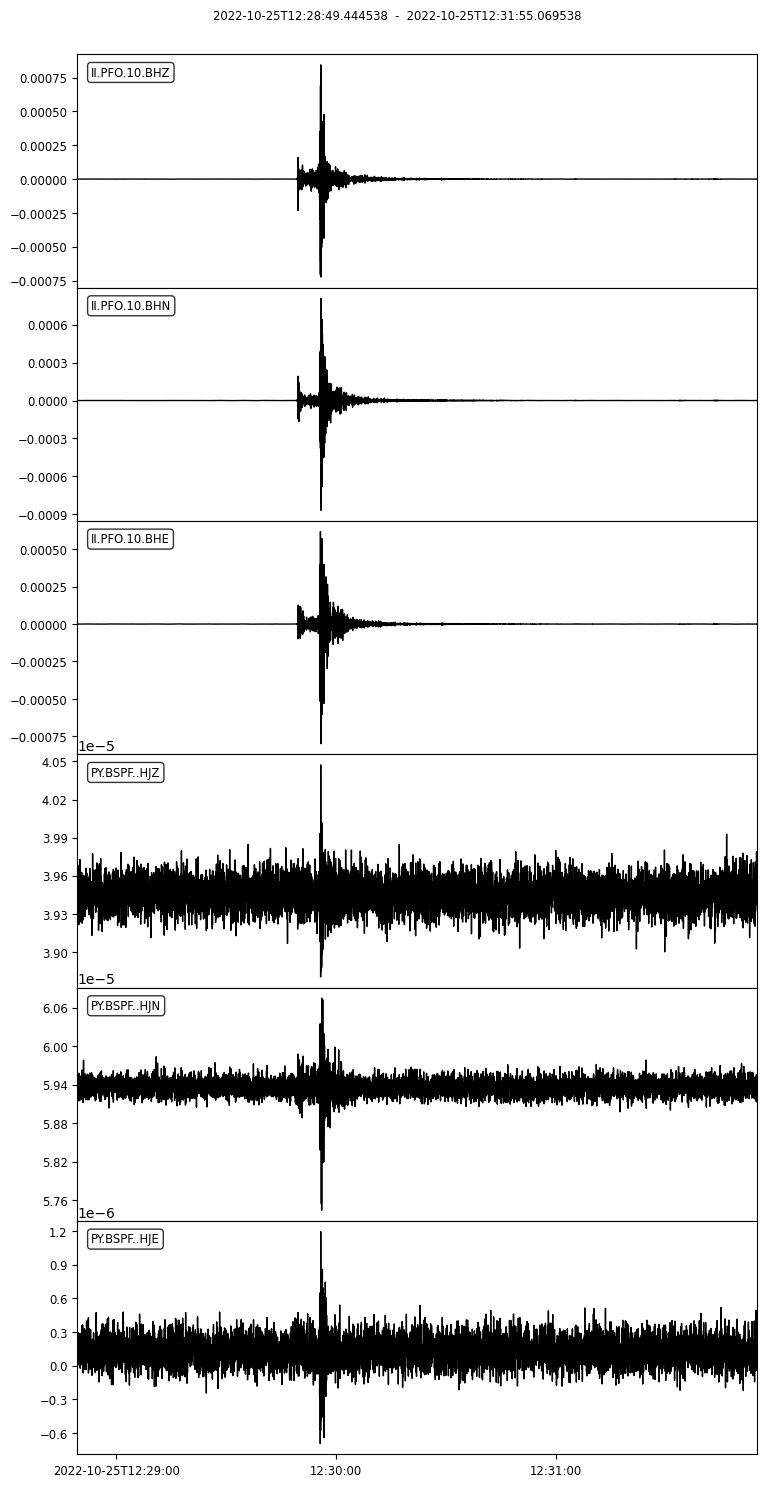

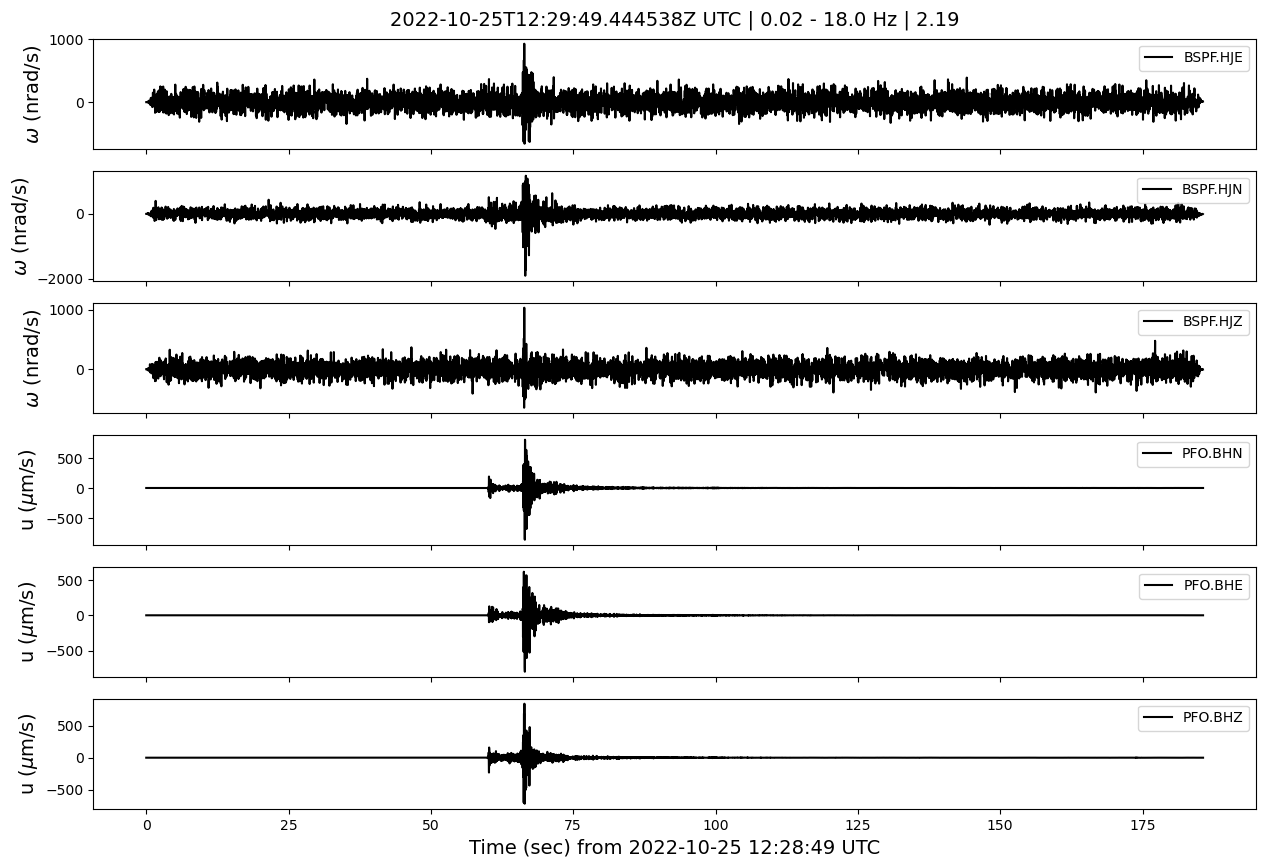


   -> saving /home/andbro/kilauea-data/BSPF/figures/triggered2/raw/20221025T122949_M2.19_raw.png ...

   -> Done


   -> saving /home/andbro/kilauea-data/BSPF/figures/triggered2/filtered/20221025T122949_M2.19_traces.png ...

   -> Done

 -> 12 2022-10-26T02:15:00.794538Z 
 -> sensitivity removed!
 -> response removed!


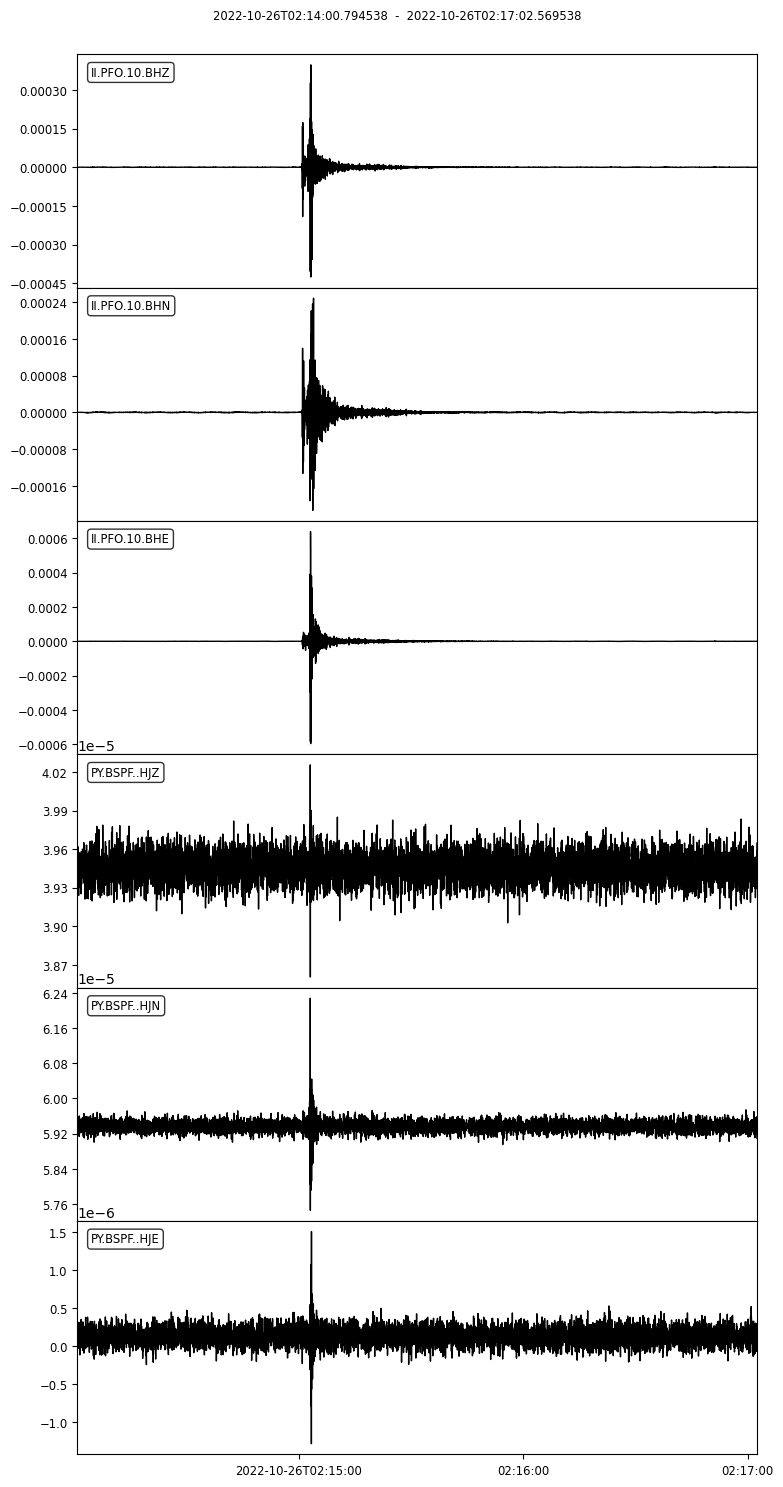

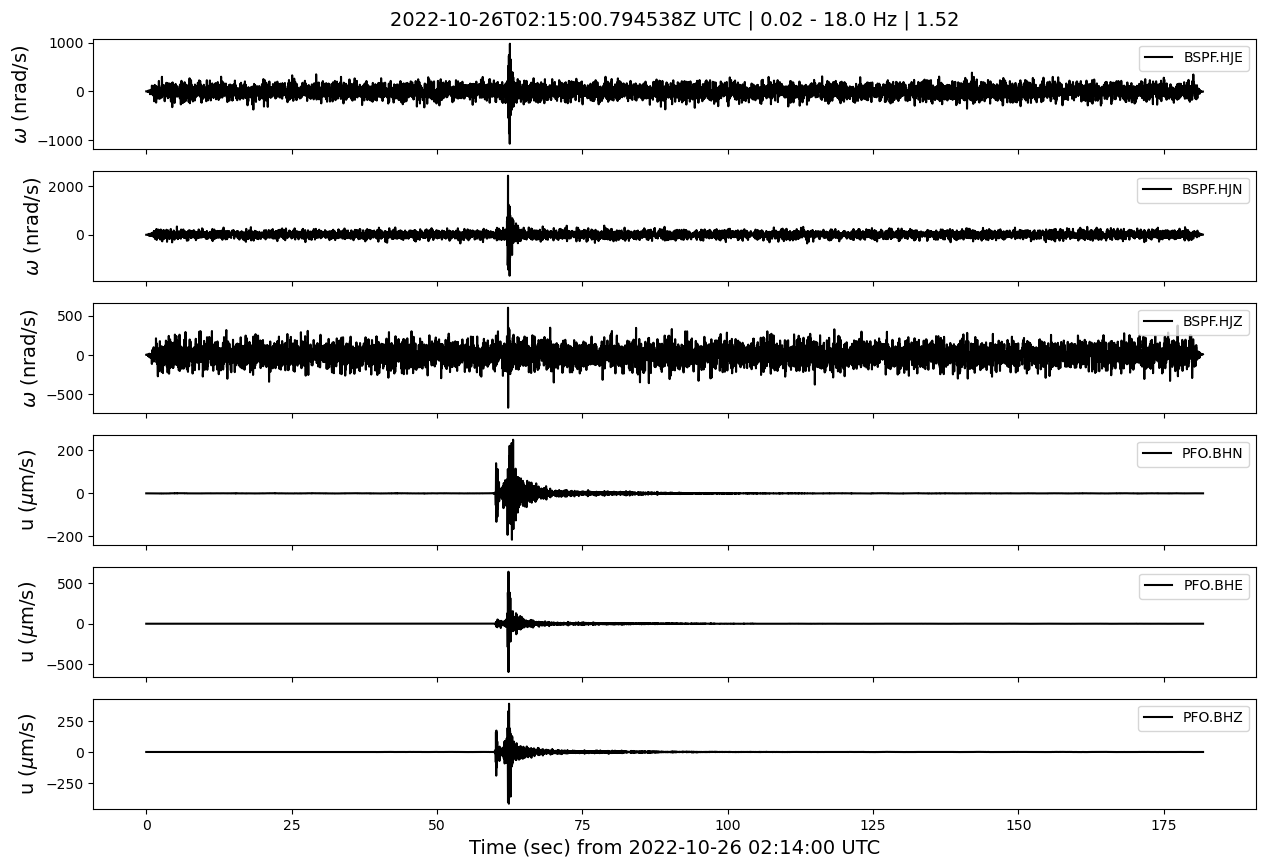


   -> saving /home/andbro/kilauea-data/BSPF/figures/triggered2/raw/20221026T021500_M1.52_raw.png ...

   -> Done


   -> saving /home/andbro/kilauea-data/BSPF/figures/triggered2/filtered/20221026T021500_M1.52_traces.png ...

   -> Done

 -> 13 2022-10-26T08:14:20.144538Z 
 -> sensitivity removed!
 -> response removed!


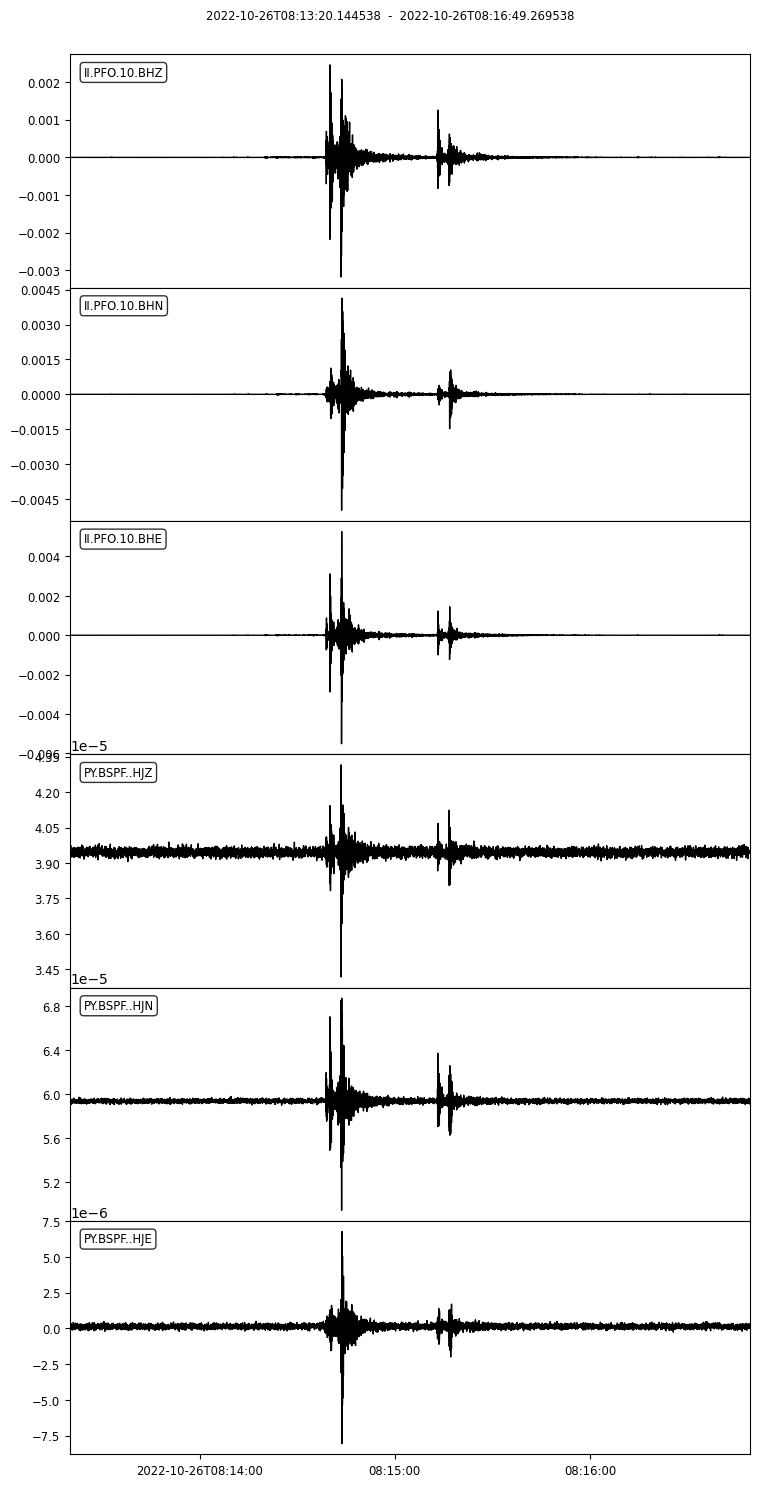

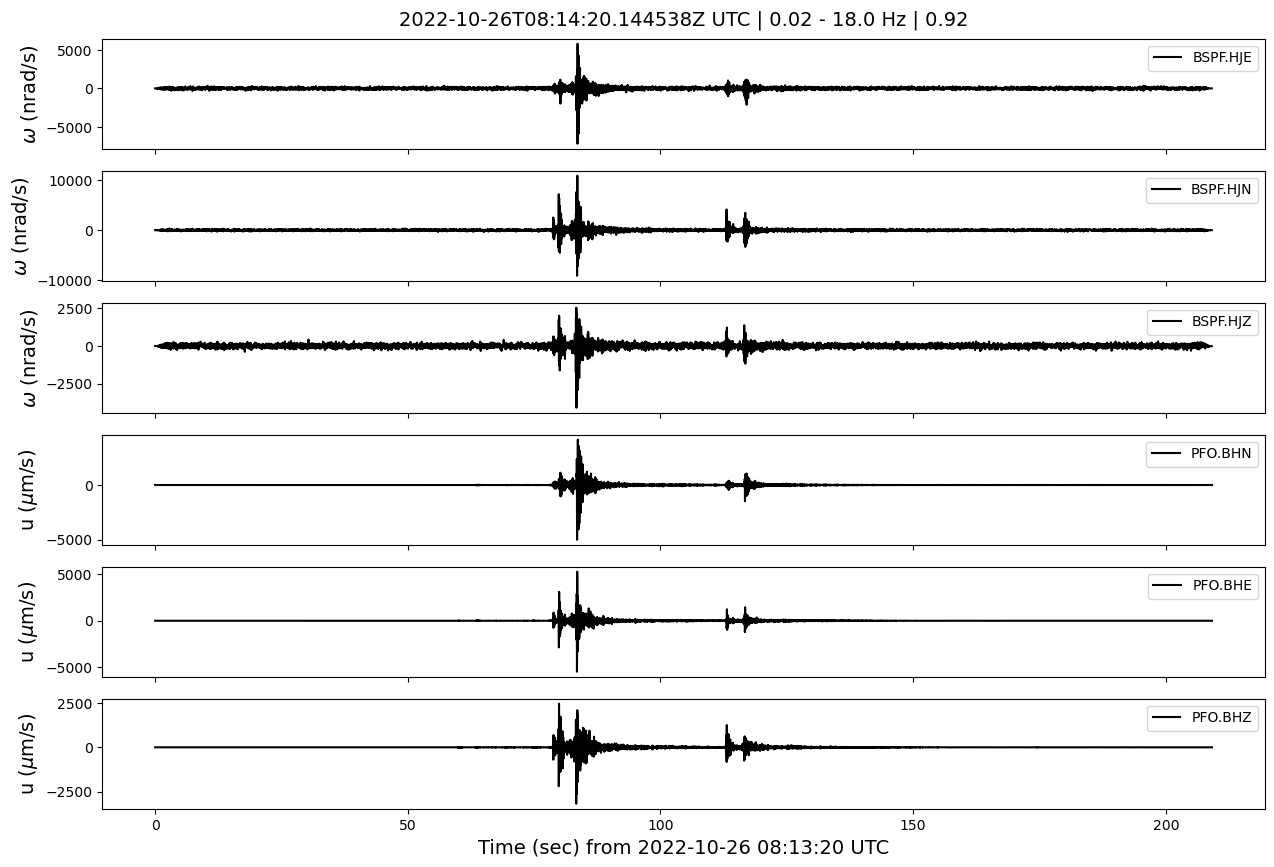


   -> saving /home/andbro/kilauea-data/BSPF/figures/triggered2/raw/20221026T081420_M0.92_raw.png ...

   -> Done


   -> saving /home/andbro/kilauea-data/BSPF/figures/triggered2/filtered/20221026T081420_M0.92_traces.png ...

   -> Done

 -> 14 2022-11-19T04:15:54.844538Z 
13.124538
 -> 15 2022-12-01T15:28:44.719539Z 
15.059539
 -> 16 2022-12-21T00:46:20.219538Z 
 -> sensitivity removed!
 -> response removed!


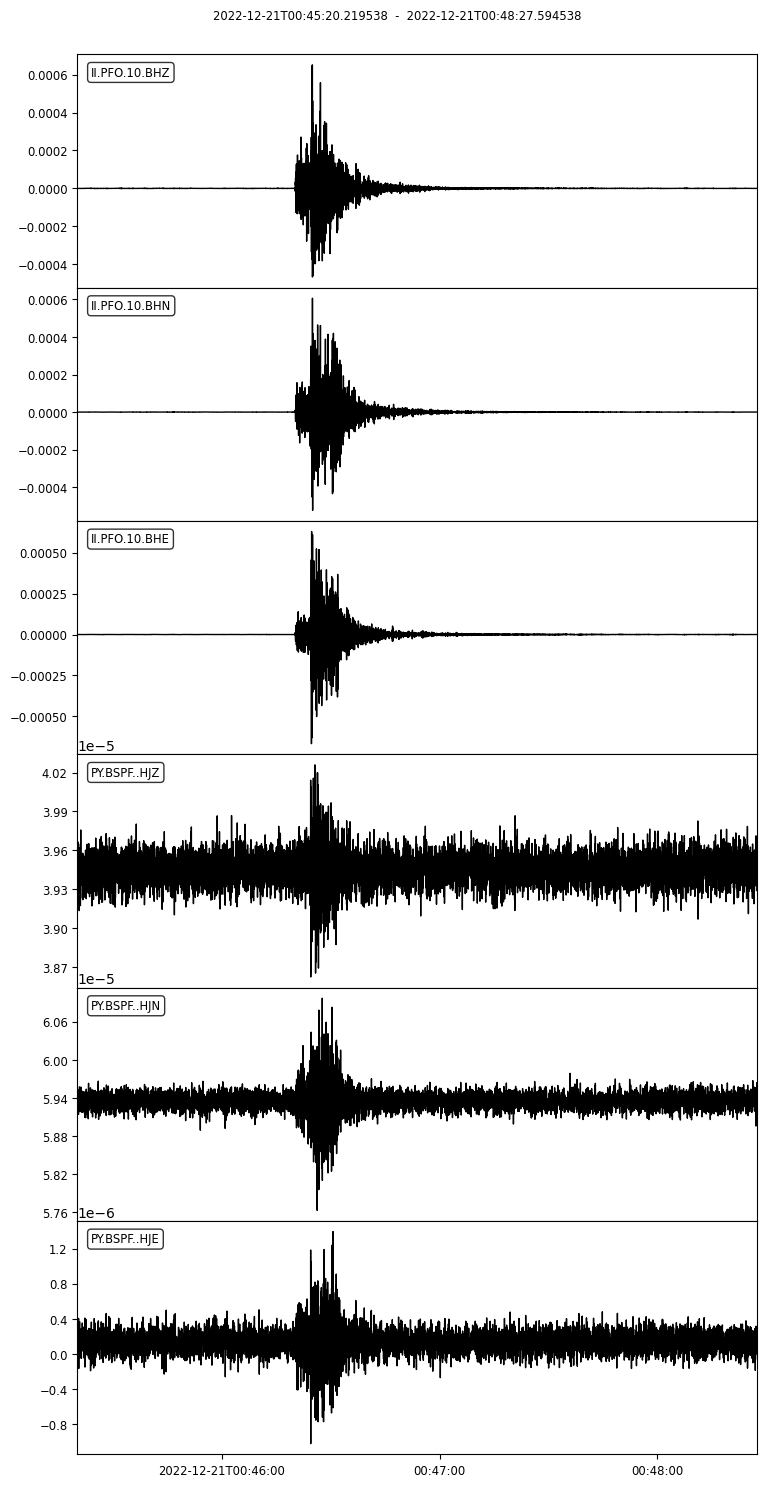

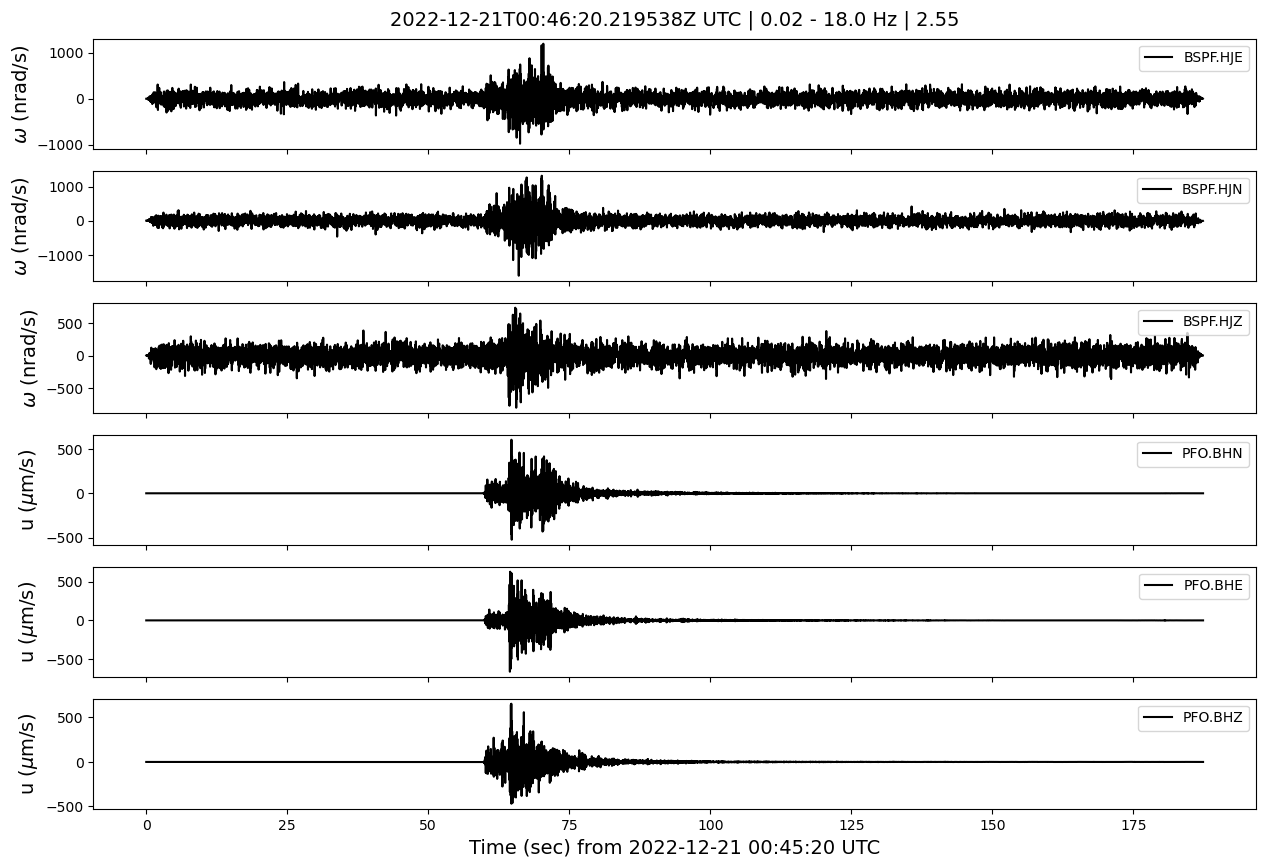


   -> saving /home/andbro/kilauea-data/BSPF/figures/triggered2/raw/20221221T004620_M2.55_raw.png ...

   -> Done


   -> saving /home/andbro/kilauea-data/BSPF/figures/triggered2/filtered/20221221T004620_M2.55_traces.png ...

   -> Done

 -> 17 2022-12-21T00:46:20.219538Z 
Failed to load waveforms!
Failed to load inventory!
Failed to load waveforms!
 -> 18 2022-12-25T08:40:45.069536Z 
Failed to load inventory!
Failed to load waveforms!
Failed to load inventory!
Failed to load waveforms!
 -> 19 2022-12-25T18:53:21.769536Z 
Failed to load inventory!
Failed to load waveforms!
Failed to load inventory!
Failed to load waveforms!
 -> 20 2022-12-31T11:40:58.269538Z 
3315.059538
 -> 21 2022-12-31T12:12:29.944538Z 
Failed to load inventory!
Failed to load waveforms!
Failed to load inventory!
Failed to load waveforms!
 -> 22 2022-12-31T16:40:11.344539Z 
Failed to load inventory!
Failed to load waveforms!
Failed to load inventory!
Failed to load waveforms!
 -> 23 2023-01-02T03:20:21.994538Z 
Fail

In [19]:

errors = []
details = False

for jj, ev in enumerate(tqdm(events.index)):
# for jj, ev in enumerate([0,1]):
    
    print(f" -> {jj} {events.origin[jj]} ")
    
    
    cat_time = cat.events[jj].origins[0].time
    if abs(events.origin[jj] - cat_time) > 10:
        print(abs(events.origin[jj] - cat_time))
        continue
        
    
    ## configurations
    config['title'] = f"{events.origin[jj]} UTC"
    config['tbeg'] = obs.UTCDateTime(str(events.origin[jj]))
    config['fmin'], config['fmax'] = 0.02, 18.0
    
    config['tend'] = obs.UTCDateTime(events.origin[jj]) + events.duration[jj] + 10
    
    ## load and process blueSeis data
    try:
        py_bspf0, py_bspf_inv = __request_data(config['seed_blueseis'], config['tbeg'], config['tend'])
        
    except Exception as e:
        print(e) if details else None
        print(f" -> failed to request blueseis for event: {ev}") if details else None
        errors.append(f" -> failed to request blueseis for event: {ev}")
        continue
        
        
    ## load and process seismometer data
    try:        
        ii_pfo0, ii_pfo_inv = __request_data(config['seed_seismometer'], config['tbeg'], config['tend'])
        
    except Exception as e:
        print(e) if details else None
        print(f" -> failed to request seismometer for event: {ev}") if details else None
        errors.append(f" -> failed to request seismometer for event: {ev}")
        continue


    if py_bspf0 is None or ii_pfo0 is None:
        continue
        
        
    ## processing data
#     py_bspf = __process_bspf(config, py_bspf0, py_bspf_inv)
#     ii_pfo = __process_xpfo(config, ii_pfo0, ii_pfo_inv)

    py_bspf0.resample(40)
    
    ## joining data
    
    st0 = py_bspf0
    st0 += ii_pfo0    
    
    st = st0.copy() 
    st.detrend("linear")
    st.taper(0.01)
    st.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)
    
    event_name = str(events.origin[jj]).replace("-","").replace(":","").replace(" ", "_").split(".")[0]
    
    event_name += f"_M{cat.events[jj].magnitudes[0].mag}"
    
    
    ## plotting
    
    fig = st0.plot(equal_scale=False);

    fig1 = __makeplot(config, st)

#     fig2 = __makeplotStreamSpectra2(st, config, fscale="linlin");
    
    ## saving figures
    __savefig(fig, outpath=config['outpath_figs']+"raw/", outname=f"{event_name}_raw", mode="png")        
    
    __savefig(fig1, outpath=config['outpath_figs']+"filtered/", outname=f"{event_name}_traces", mode="png")
    
#     __savefig(fig2, outpath=config['outpath_figs']+"spectra/", outname=f"{event_name}_spectra", mode="png")

pprint.pprint(errors)